## Bag of Words modeling approach implemented below - produces some cohesive topics, but could be clearer. Steps taken here:
- Added functions to clean compiled Yelp reviews:
 - BeautifulSoup html.parser used to strip html tags
 - Accent characters removed with package unicodedata
 - Contraction Map object built; incorporated in function to expand contractions
 - Special characters removed, including digits when embedded in special character strings
 - NLTK stemmer used for stemming (reducing words to root regardless of meaning)
 - Spacy lemmatizer used for lemmatizing (reducing words to roots that still have meaning)
 - English stopwords list imported from NLTK, tailored to include Zazie-specific over-used/low-information words
 - Stopwords removed after tokenizing corpus (tokenized by Spacy)
 - All of this tied together into one function: normalize_corpus
 
### First pass results:
- For-loops indicate that topics divide reliably into 2 when looking only at negative reviews, and those two topics are distinct after tailoring stopwords for negative reviews
- LDA does pretty well but sometimes NMF does better and LSI never does best
- Bigrams can be helpful but trigrams have not been
- Some customers are angry about time and charges - that's one topic
- However, the other negative reviews topic appears to be about happy brunch experiences, and it dominates many reviews

### Next steps:
- Track down those 1-star reviews that are dominated by happy-topic words (pancakes, breakfast, etc.) - what's going on there?
- Consider culling words that occur > some % of time and < than some other % of time
- Consider TextRank modeling approach
- Consider applying association rules, lift, and apriori model concepts
- Consider heirarchical Dirichlet process

Much thanks to this tutorial in particular: 
https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

### Data scraped page-by-page from Yelp to avoid violating Yelp's TOS, then processed into page-specific DFs using variations on this code:

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re 

#for reviews that Yelp includes in the ratings calculations and main review page

#pull each page off of yelp in HTML
r = requests.get('https://www.yelp.com/biz/zazie-san-francisco')
html = r.text
soup = BeautifulSoup(html, "html5lib")

#use BeautifulSoupto extract components of interest from each review
author = soup.find_all(itemprop = 'author')
date = soup.find_all(itemprop = 'datePublished')
stars = soup.find_all(itemprop = 'ratingValue')
review_body = soup.find_all(itemprop = 'description')

#compile components of interest as dataframe - relies on the assumption of 1:1:1:1 matches throughout each HTML page
#this assumption seems robust for the reviews that Yelp includes, but is often violated for Yelp's excluded reviews
df1 = pd.DataFrame({'author':author,'date':date,'stars':stars[1:],'review_body':review_body})

#clean that dataframe of lingering tags to either side of each component of interest
for i in range(len(df1)):
    df1.author[i] = re.sub('<meta content="','',str(df1.author[i]))
    df1.author[i] = re.sub('" itemprop="author"/>','',str(df1.author[i]))
    df1.date[i] = re.sub('<meta content="','',str(df1.date[i]))
    df1.date[i] = re.sub('" itemprop="datePublished"/>','',str(df1.date[i]))
    df1.stars[i] = re.sub('<meta content="','',str(df1.stars[i]))
    df1.stars[i] = re.sub('" itemprop="ratingValue"/>','',str(df1.stars[i]))
    df1.review_body[i] = re.sub('<p itemprop="description">','',str(df1.review_body[i]))
    df1.review_body[i] = re.sub('</p>','',str(df1.review_body[i]))

#run this only every once in a while, to make sure these commands are doing what they are supposed to be doing
print(df1.shape)
df1.head()

#for reviews the Yelp excludes from the ratings calcuations and main review page

#at first the proces is almost exactly as above:
r = requests.get('https://www.yelp.com/not_recommended_reviews/zazie-san-francisco?not_recommended_start=10')
html = r.text
soup = BeautifulSoup(html, "html5lib")

#tags are a bit different for excluded reviews on Yelp
author = soup.find_all(class_ = 'user-display-name') 
date = soup.find_all(class_ = 'rating-qualifier')
stars = soup.find_all(width = '84')
review_body = soup.find_all(lang = 'en') #use only review_body[1:]

#the assumption of a 1:1:1:1 ratio is often violated in the excluded reviews pages
#instead of finding way to patch the ~5 out of ~40 pages with this issue together, or fix them in .csv, excluded them from analysis
#if power turns out to be a limiting factor later on and an added 5 pages of reviews would help, might revisit this step
df1 = pd.DataFrame({'author':author,'date':date,'stars':stars,'review_body':review_body[1:]})
df1.head()

for i in range(len(df1)):
    df1.author[i] = re.sub('<span class="user-display-name" ','',str(df1.author[i]))
    df1.author[i] = re.sub('</span>','',str(df1.author[i]))
    df1.date[i] = re.sub('<span class="rating-qualifier">','',str(df1.date[i]))
    df1.date[i] = re.sub('</span>','',str(df1.date[i]))
    df1.stars[i] = re.sub('<img alt="','',str(df1.stars[i]))
    df1.stars[i] = re.sub(' star rating" class="offscreen" height="303" src="https://s3-media2.fl.yelpcdn.com/assets/srv0/yelp_design_web/9b34e39ccbeb/assets/img/stars/stars.png" width="84"/>','',str(df1.stars[i]))
    df1.review_body[i] = re.sub('<p lang="en">','',str(df1.review_body[i]))
    df1.review_body[i] = re.sub('</p>','',str(df1.review_body[i]))

#again, only inspect as necessary
print(df1.shape)
df1

#to build a full df out of each type of review (included and excluded, separately)
dfs = [df1,df2,df3,df4] #note: many more dfs than provided in this example

#use (within included or within excluded reviews df sets) any df to provide headers as seed to build off of 
#that on will get inclued twice, but a Pandas remove duplicate row command takes care of that issue later
DF = df40
for i in dfs:
    DF = DF.append(i, ignore_index=True)

#this is particularly necessary for the excluded reviews, which have overlapping review content between pages
#but also necessary for the included reviews, as described above
DF = DF.drop_duplicates()

### Then moving on to work with compiled reviews as below:

In [2]:
import numpy as np
import pandas as pd
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata

In [3]:
#import Spacy en_core_web_md model: 
#"English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl...
#... Assigns word vectors, context-specific token vectors, POS tags, dependency parse and named entities."
#OntoNotes data sources: "telephone conversations, newswire, newsgroups, broadcast news, broadcast conversation, weblogs"

nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.append('zazie')
stopword_list.append('food')
stopword_list.append('egg')
stopword_list.append('french')
stopword_list.append('good')

In [4]:
#export non-tokenized .csv with stopwords removed
included_reviews = pd.read_csv('/home/cynthiaorourke/Desktop/Yelp_Zazie/reviews_included.csv')

#and inspect it to see what it looks like
print(included_reviews.shape)
included_reviews.head()

(4156, 5)


,Unnamed: 0,author,date,stars,review_body
0,0,Bob U.,2019-03-04,5.0,love this Cole Valley spot for brunch. close e...
1,1,Carol H.,2019-03-08,4.0,Discovered this neighborhood bistro in Cole Va...
2,2,Jamie P.,2019-03-02,4.0,My coworkers and I decided to pay a visit duri...
3,3,Eileen W.,2019-02-24,5.0,I can't believe I haven't reviewed this place ...
4,4,Donna T.,2019-02-14,5.0,One of the most delightful brunch joints you'l...


### Functions built for text preprocessing:

In [5]:
#function relying on BeautifulSoup to strip out any lingering html tags (there shouldn't be any)
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [6]:
#function to remove characters that are odd for the English language, e.g., 'ě'
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [7]:
#create object for contract expansion
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [9]:
#function to expand contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [10]:
#function to remove special characters and digits embedded in special character strings
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [11]:
#function to stem text, which reduces it to its exact core component, sometimes at the cost of meaning
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [12]:
#function to lemmatize text, which is like stemming but with a preference for meaning over exact matches
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [13]:
#function to remove basic Spacy stopwords and any project-specific stopworkds that you've appended to that list
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [14]:
#function to tie all of the previous functions together
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    #normalize each document in the corpus
    for doc in corpus:
        #strip HTML tags
        if html_stripping:
            doc = strip_html_tags(doc)
        #remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        #expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        #lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        #remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        #lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        #remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        #remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        #remove stopwords (both generic and Zazie-specific)
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [15]:
#pre-process reviews text to normalize as described above
#this will not be appropriate for all downstream purposes
included_reviews['review_cleaned'] = normalize_corpus(included_reviews['review_body'])
norm_corpus = list(included_reviews['review_cleaned'])

### Export and save cleaned "norm_corpus" locally to skip this preprocessing step in the future:

In [15]:
included_reviews.to_csv('/home/cynthiaorourke/Desktop/Yelp_Zazie/cleaned_inc_reviews.csv')

In [102]:
#create a basic pre-processed corpus
#but don't lowercase so that we can get POS context out of capitalizations
#also no need to lemmatize; working with sentences here, pre/sufixes will add context too
corpus = normalize_corpus(included_reviews['review_body'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

In [ ]:
#demo for POS tagging for sample review
#note different formats required for Spacy vs NLTK tagging
sentence = str(included_reviews.iloc[1].review_body)
sentence_nlp = nlp(sentence)

#POS conventions for these two taggers are derived generally from this: 
#http://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/data/Penn-Treebank-Tagset.pdf

In [16]:
#POS tagging with Spacy's native POS tagging - developed by the same guy (below) as the NLTK averaged perceptron tagger
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
spacy_example = pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])
spacy_example.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cynthiaorourke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Word,POS tag,Tag type
0,Discovered,VBN,VERB
1,this,DT,DET
2,neighborhood,NN,NOUN
3,bistro,NN,NOUN
4,in,IN,ADP


In [74]:
#download NLTK 'averaged perceptron tagger' model
#POS tagging faces a similar challenge to recommender or shopping-basket-analysis systems: sparse data-sets, which is to say...
#... very many rows that are mostly full of zeroes (tokenized words skew towards rare)
#the averaged_perceptron_tagger below is a pretty high-accuracy and yet parsimonious (200 lines of code) parser... 
#... that is simple enough for you to tailor to your purposes as desired, with assumptions clearly laid out line-item:
#http://www.nltk.org/_modules/nltk/tag/perceptron.html
#prose description of approach and rationale: https://explosion.ai/blog/part-of-speech-pos-tagger-in-python
nltk.download('averaged_perceptron_tagger')

#POS tagging with NLTK's averaged perceptron, for comparison, is not as complete as Spacy tagging
nltk_pos_tagged = nltk.pos_tag(sentence.split())
nltk_example = pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])
nltk_example.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cynthiaorourke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Word,POS tag
0,Discovered,VBN
1,this,DT
2,neighborhood,NN
3,bistro,NN
4,in,IN


### Update: I am kind of in love with the author of the averaged_perceptron_tagger, or at least their brain: 
"I doubt there are many people who are convinced that’s the most obvious solution to the problem, but whatever. We’re not here to innovate, and this way is time tested on lots of problems. If you have another idea, run the experiments and tell us what you find. Actually I’d love to see more work on this, now that the averaged perceptron has become such a prominent learning algorithm in NLP."

### Now for some shallow parsing work, just to see what that looks like on this corpus:

In [62]:
from nltk.corpus import conll2000
nltk.download('conll2000')

[nltk_data] Downloading package conll2000 to
[nltk_data]     /home/cynthiaorourke/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.


In [63]:
data = conll2000.chunked_sents()

In [64]:
data

[Tree('S', [Tree('NP', [('Confidence', 'NN')]), Tree('PP', [('in', 'IN')]), Tree('NP', [('the', 'DT'), ('pound', 'NN')]), Tree('VP', [('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB')]), Tree('NP', [('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN')]), ('if', 'IN'), Tree('NP', [('trade', 'NN'), ('figures', 'NNS')]), Tree('PP', [('for', 'IN')]), Tree('NP', [('September', 'NNP')]), (',', ','), ('due', 'JJ'), Tree('PP', [('for', 'IN')]), Tree('NP', [('release', 'NN')]), Tree('NP', [('tomorrow', 'NN')]), (',', ','), Tree('VP', [('fail', 'VB'), ('to', 'TO'), ('show', 'VB')]), Tree('NP', [('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN')]), Tree('PP', [('from', 'IN')]), Tree('NP', [('July', 'NNP'), ('and', 'CC'), ('August', 'NNP')]), Tree('NP', [("'s", 'POS'), ('near-record', 'JJ'), ('deficits', 'NNS')]), ('.', '.')]), Tree('S', [('Chancellor', 'NNP'), Tree('PP', [('of', 'IN')]), Tree('NP', [('the', 'DT'), ('Exchequer', 'NNP')]), Tree('NP', [('Nigel',

In [65]:
len(data)

10948

In [95]:
train_data = data[:10800]
test_data = data[10800:] 

print(len(train_data), len(test_data))
print(train_data[1])

10800 148
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [96]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [71]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

In [97]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# define the chunker class
class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)
  
# train chunker model  
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  89.7%%
    Precision:     80.8%%
    Recall:        85.8%%
    F-Measure:     83.2%%


In [90]:
#going to use a subset of the sample review because otherwise the chunk tree is unreadably detailed
print((len(nltk_pos_tagged))/2)

105.0


In [98]:
#create the chunk tree
chunk_tree = ntc.parse(nltk_pos_tagged[175:])
print(chunk_tree)

(S
  there/RB
  when/WRB
  (NP they/PRP)
  (VP opened/VBD)
  (PP at/IN)
  (NP 5pm./CD Tuesday/NNP)
  (NP they/PRP)
  (VP have/VBP)
  (NP no/DT cork/NN)
  fee./RB
  (VP Giving/VBG)
  (NP a/DT four/CD star/NN rating/NN)
  -/:
  minus/CC
  (NP one/CD star/NN)
  (PP for/IN)
  (NP not/RB providing/VBG)
  (NP a/DT detailed/JJ receipt/NN)
  -/:
  only/RB
  (NP the/DT credit/NN card/NN charges/NNS)
  (VP print/VBP)
  (NP out./NNS))


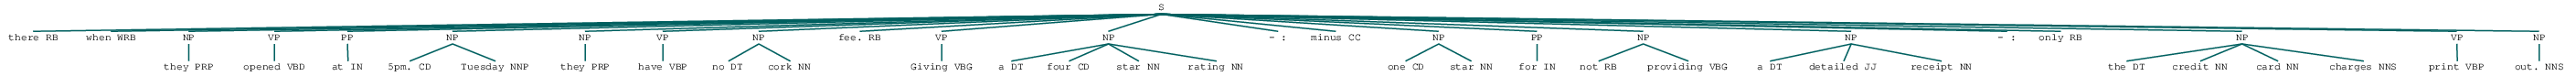

In [99]:
from IPython.display import display

display(chunk_tree)

### Ok... that makes sense, might spin back around to that, but for now some bag 'o words sentiment analysis:

In [100]:
from afinn import Afinn
af = Afinn()

In [103]:
#compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
#sentiment statistics per ordinal star bin
df = pd.DataFrame([list(included_reviews['stars']), sentiment_scores, sentiment_category]).T
df.columns = ['stars', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['stars']).describe()
#well that checks out - sentiment score strongly correlates with star ratings, in the expected direction
#a higher mean and a higher star number indicates a higher demonstrated and a higher stated sentiment score, respectively

sentiment_score                                                    
                count       mean        std   min  25%   50%   75%    max
stars                                                                    
1.0             114.0  -1.631579   9.916700 -62.0 -5.0  -1.0   3.0   20.0
2.0             195.0   7.071795  10.569113 -21.0  0.0   5.0  11.0   53.0
3.0             481.0  10.295218  10.211929 -11.0  4.0   9.0  15.0   71.0
4.0            1493.0  14.331547  10.815318 -30.0  7.0  12.0  19.0   89.0
5.0            1873.0  16.016551  12.329272  -8.0  8.0  14.0  22.0  143.0

In [104]:
# let's look at one of these cleaned reviews, vs the original:
print('raw:',included_reviews.iloc[0,4])
print('...')
print('cleaned:',included_reviews.iloc[0,5])

raw: love this Cole Valley spot for brunch. close enough to Golden Gate Park to walk there afterwards and work off the excellent food!

great selection of omelettes, benedicts and pancakes. interesting mimosa choices too. there are some rotating brunch specialties too

I know the line can be very long, but it was raining last time I went and I think people gave up because they didn't want to stand in the rain. I was seated in about 20 mins

I can't wait to come back and try some other dishes.

they pride themselves on the no tipping policy (yay) and service is fantastic, start to finish. not at all rushed although you might not blame them since there are always people waiting to be seated.
...
cleaned: love cole valley spot brunch close enough golden gate park walk afterwards work excellent great selection omelette benedict pancake interesting mimosa choice rotate brunch specialty know line long rain last time go think people give not want stand rain seat min not wait come back try dis

Text(0.5, 0.98, 'Word counts by sentiment and stars')

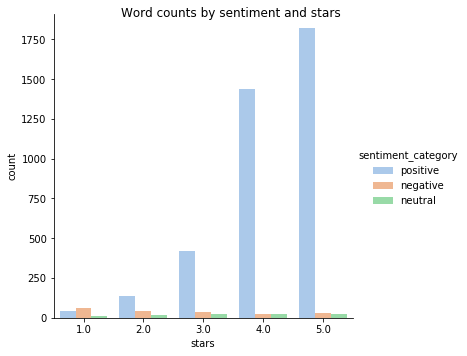

In [110]:
#vizualizing these scores:
import seaborn as sns 

fc = sns.catplot(x = 'stars', hue = 'sentiment_category', 
                    data = df, kind = 'count', 
                    palette = 'pastel')

fc.fig.suptitle('Word counts by sentiment and stars')
#overwhelmingly positive in all but the bottom two bins, and even there more positive than negative

In [111]:
pos_idx = df[(df.sentiment_score == 53)].index[0] #had to go back and adjust these upper/lower bounds...
neg_idx = df[(df.sentiment_score == -13)].index[0] #... after adding in more stopwords

print('Most negative review:', included_reviews.iloc[neg_idx][['date']][0], included_reviews.iloc[neg_idx][['author']][0])
print(included_reviews.iloc[neg_idx][['review_body']][0])
print()
print('Most positive review:', included_reviews.iloc[pos_idx][['date']][0], included_reviews.iloc[pos_idx][['author']][0])
print(included_reviews.iloc[pos_idx][['review_body']][0])

#customer B B. is now no longer the most negative review! stopwords additions (appends) changed that
#that dubious honor now belongs to customer Ashley M., and it's a recent one

Most negative review: 2018-11-04 Ashley M.
I split the bill with my boyfriend and was somehow charged the full bill, although he was also charged half. I tried to call once but got no assistance. The service and food were mediocre for the price, now that i was over charged it makes it even worse! We will not be coming back

Most positive review: 2017-02-01 Harmony C.
The perfect place for brunch. I quite enjoyed my experience here at Zazie. 

My boyfriend and I arrived on a Monday at noon after exploring The Haight and was seated immediately. Per our suggestion, we were seated in the back patio, and it was beautiful. The perfect patio, because it was enclosed with a roof, and also had heaters all around. Service was amazing, and we were asked immediately if we were served yet. 

The boyfriend ordered the Monaco (eggs benedict) and I ordered the Miracle Pancakes (Lemon ricotta flavor). The food arrived after 15 minutes. 

Let's talk about the food:

The miracle pancakes were definitely 

In [115]:
df.head()

,stars,sentiment_score,sentiment_category
0,5,0.345,positive
1,4,0.217,positive
2,4,0.153,positive
3,5,0.313,positive
4,5,0.248,positive


In [112]:
###ok, moving on to score both the polarity and the objectivity of each review:

from textblob import TextBlob

# compute sentiment scores (polarity, range -1 to 1) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in included_reviews['review_cleaned']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]

# sentiment statistics per news category
df = pd.DataFrame([list(included_reviews['stars']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['stars', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['stars']).describe()

#interesting - a 3-star review is actually the most negative

sentiment_score                                                       
                count      mean       std    min    25%    50%      75%  max
stars                                                                       
1.0             114.0 -0.051737  0.180583 -0.667 -0.110 -0.032  0.04725  0.6
2.0             195.0  0.044882  0.142211 -0.567 -0.032  0.052  0.13550  0.5
3.0             481.0  0.136963  0.159927 -1.000  0.043  0.141  0.21400  0.8
4.0            1493.0  0.248451  0.162664 -0.600  0.152  0.237  0.33700  1.0
5.0            1873.0  0.300344  0.168215 -0.800  0.200  0.285  0.39600  1.0

In [116]:
pos_idx = df[(df.sentiment_score == 1)].index[0] 
neg_idx = df[(df.sentiment_score == -1)].index[0] 

print('Most negatively polar review:', included_reviews.iloc[neg_idx][['date']][0], included_reviews.iloc[neg_idx][['author']][0])
print(included_reviews.iloc[neg_idx][['review_body']][0])
print()
print('Most positively polar review:', included_reviews.iloc[pos_idx][['date']][0], included_reviews.iloc[pos_idx][['author']][0])
print(included_reviews.iloc[pos_idx][['review_body']][0])

#looks like polarity is biased towards shorter reviews, which makes sense
#it's easier to take an unambiguous stance when using very few words - less chance of message confusion

Most negatively polar review: 2008-05-19 Ron S.
breakfast is good but the wait makes the experience horrible...

Most positively polar review: 2015-11-25 Nicholas F.
Absolutely delicious brunch menu! The french toast is a must try.


### Bag 'o words topic modeling!

In [118]:
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import os

#more imports for visualization
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

#Spacy and family imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
!python -m spacy download en_core_web_lg


    Linking successful
    /home/cynthiaorourke/anaconda3/lib/python3.7/site-packages/en_core_web_lg
    -->
    /home/cynthiaorourke/anaconda3/lib/python3.7/site-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [26]:
#load a different Spacy model this time
#en_core_web_lg: "English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl... 
#... Assigns word vectors, context-specific token vectors, POS tags, dependency parse and named entities."
#sources: OntoNotes 5, Common Crawl
nlp = spacy.load('en_core_web_lg')

In [27]:
#identify and visualize named entities in the text

doc = nlp(included_reviews['review_body'][4])
spacy.displacy.render(doc, style='ent',jupyter=True)

#sometimes nails it, sometimes (Eggs en Fonte the person?) does not, but the reason for the mistake is clear

In [119]:
#define punctuations, define and add on to stopwords

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords.append('zazie') #adding some of the more heavily used and less-apparently informative terms from the first round of modeling
stopwords.append('food')
stopwords.append('french')
stopwords.append('egg')
stopwords.append('good')
stopwords.append('brunch') #round two of that, following productive outcome of round 1
stopwords.append('place')
stopwords.append('restaurant')

In [121]:
print(stopwords) #not that not and without and no are included in this list, which could be a problem with the bag 'o words approach

['due', 'eleven', 'neither', 'such', 'were', 'perhaps', 'once', 'her', 'ever', 'somewhere', 'three', 'unless', 'very', 'without', 'whom', 'but', 'either', 'have', 'himself', 'seemed', 'may', 'back', 'thereby', 'against', 'must', 'yourselves', 'before', 'fifteen', 'any', 'even', 'it', 'someone', 'every', 'towards', 'well', 'should', 'get', 'does', 'move', 'bottom', 'nevertheless', 'say', 'latterly', 'down', 'none', 'both', 'much', 'per', 'least', 'elsewhere', 'do', 'around', 'wherein', 'under', 'with', 'serious', 'between', 'across', 'all', 'last', 'yet', 'can', 'some', 'at', 'namely', 'an', 'along', 'own', 'thence', 'could', 'beforehand', 'nowhere', 're', 'also', 'sometimes', 'us', 'what', 'eight', 'forty', 'call', 'several', 'mine', 'our', 'next', 'somehow', 'became', 'during', 'he', 'former', 'herself', 'ten', 'about', 'whereas', 'since', 'wherever', 'one', 'no', 'still', 'out', 'up', 'anywhere', 'whereafter', 'few', 'ours', 'six', 'whereupon', 'although', 'meanwhile', 'quite', 'behi

In [126]:
#define another parser for these reviews
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [127]:
tqdm.pandas()
included_reviews['processed_reviews'] = included_reviews['review_body'].progress_apply(spacy_tokenizer)

100%|██████████| 4156/4156 [00:05<00:00, 693.53it/s]


In [181]:
#creating a vectorizer along with those custom stopwords
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words=stopwords, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(included_reviews['processed_reviews'])

In [129]:
#this is an arbitrary number
#k-selection techniques are described below
#heirarchical Dirichlet allocation would be able to identify a cluster number post priori
NUM_TOPICS = 10

### Thus begins a bucket 'o models approach for bag 'o works modeling:

In [131]:
#functions for printing keywords for each topic, dropping in whatever model
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [183]:
#Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)
#should cross-validation have been applied?

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


### A good discussion of some of the LDA parameters, for example alpha and beta:
https://datascience.blog.wzb.eu/2017/11/09/topic-modeling-evaluation-in-python-with-tmtoolkit/

In [134]:
#keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('mimosa', 360.1031222704507), ('benedict', 334.0249302230182), ('crab', 326.72936873269106), ('mer', 199.72448154748156), ('wait', 179.0273119992185), ('toast', 168.74605600590473), ('croque', 163.2483307249346), ('patio', 142.37683079796815), ('worth', 128.08407413535448), ('little', 126.85309043830254)]
Topic 1:
[('tip', 128.7350544669879), ('staff', 90.15849466830696), ('pay', 79.86808827684783), ('wife', 77.6666027944516), ('employee', 72.71328256758669), ('work', 68.8883291596876), ('include', 68.81297967209217), ('live', 66.2280474342531), ('price', 46.9821336959643), ('insurance', 45.616372733548566)]
Topic 2:
[('pancake', 1848.8356737838187), ('toast', 1529.5214631642132), ('wait', 1094.5610686051298), ('order', 1015.7013084463285), ('come', 913.8281035444564), ('like', 728.582750905913), ('benedict', 674.5769627862462), ('try', 670.5971987013792), ('poach', 660.123603956297), ('potato', 635.6010846014321)]
Topic 3:
[('wait', 2217.107060039216), ('time', 1

In [187]:
#alternatively: Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized) 

In [135]:
#keywords for topics clustered by Non-Negative Matrix Factorization
print("NMF Model:")
selected_topics(nmf, vectorizer)

#these topics seem much more cohesive than the LDA topics (at least at k = 10)

NMF Model:
Topic 0:
[('table', 5.061904762722458), ('seat', 2.8933990436479524), ('time', 2.1215136717789895), ('people', 1.9342461991524587), ('patio', 1.8678178275958004), ('little', 1.717881026937952), ('service', 1.705609215687438), ('friend', 1.6383986277005453), ('sit', 1.56614070712843), ('outside', 1.5472199498270034)]
Topic 1:
[('pancake', 6.922831968715043), ('gingerbread', 2.121191034111079), ('lemon', 2.0995712512864553), ('curd', 1.5217058613639882), ('pear', 0.788059047293408), ('miracle', 0.7840837087566628), ('time', 0.43023993390587667), ('try', 0.42110913350545937), ('sweet', 0.4049636305312112), ('delicious', 0.3954134098473704)]
Topic 2:
[('dinner', 3.404426596341486), ('menu', 1.6047947350909926), ('night', 1.5443039939761987), ('time', 1.47788682353558), ('dessert', 1.2289016612521884), ('wine', 1.1781822479368338), ('try', 1.171238248853689), ('dish', 1.1044108872636333), ('delicious', 0.9923132860692369), ('soup', 0.8538996676349172)]
Topic 3:
[('toast', 6.96852

In [188]:
#alternatively: Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

In [136]:
#keywords for topics clustered by Latent Semantic Indexing
print("LSI Model:")
selected_topics(lsi, vectorizer)

#these topics (at k = 10) do not seem terribly cohesive

LSI Model:
Topic 0:
[('wait', 0.3604091911934145), ('come', 0.2478828394041884), ('order', 0.2162590205150129), ('toast', 0.20301928844389475), ('pancake', 0.19852350445174605), ('like', 0.18826314730249155), ('time', 0.17268927847928195), ('great', 0.15246650123984287), ('table', 0.1415972634035202), ('try', 0.14022947526533217)]
Topic 1:
[('wait', 0.5878199435526389), ('table', 0.14672313081480798), ('long', 0.11520794513726608), ('time', 0.10603579420070754), ('seat', 0.09826479426586053), ('minute', 0.09441503687832298), ('hour', 0.08782710496078369), ('worth', 0.08736437839525986), ('people', 0.07506538173661054), ('list', 0.07201818894365065)]
Topic 2:
[('dinner', 0.2615454977150865), ('great', 0.22993746826433936), ('menu', 0.14394569716611078), ('service', 0.1377011823800515), ('night', 0.13243012364164577), ('dessert', 0.11256704124177974), ('wine', 0.11064202735893919), ('like', 0.1077384107877672), ('love', 0.09960888983120575), ('dish', 0.09346712463062654)]
Topic 3:
[('toa

In [137]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

#topic 9 appears to be associated with Zazie's worker benefits
#topic 5 is largely good feels about no-corkage tuesdays
#topics 2 and 1 are huge and seem interchangeable - happy brunch outcomes, long waits 
#topics 4 and 8 appear to be about savory menu items
#topic 7 is about sweets
#topic 6 is about dinners
#topic 3 is way more about the experience than the food
#topic 10 seems pretty angry and is weirdly hyper-focused on bloody maries??

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      -66.463486  488.508209       1        1  33.388947
2      205.617813  325.378021       2        1  32.559895
8      150.750107  -27.877718       3        1  15.435284
0     -409.245728  -43.129555       4        1   6.828498
9     -148.369217 -223.633713       5        1   5.206367
1      424.385010 -204.313583       6        1   2.114007
5      466.490509  144.866791       7        1   1.715292
7      123.705070 -386.773743       8        1   1.580344
4     -367.145355  306.050720       9        1   0.750046
6      -93.505333  129.619354      10        1   0.421321, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
1815  Default  1961.000000        pancake  1961.000000  30.0000  30.0000
744   Default   905.000000         dinner   905.000000  29.0000  29.0000
234   Default  1086.000000       benedict  1086.000000  28.0000  28.0000
2632  Default  1915.000000          toast  1915.000000  27.0000  27.0000
2628  Default   563.000000            tip   563.000000  26.0000  26.0000
2270  Default  1519.000000        service  1519.000000  25.0000  25.0000
2783  Default  3542.000000           wait  3542.000000  24.0000  24.0000
1992  Default   581.000000          price   581.000000  23.0000  23.0000
2440  Default   552.000000          staff   552.000000  22.0000  22.0000
187   Default   435.000000          bacon   435.000000  21.0000  21.0000
315   Default  1262.000000      breakfast  1262.000000  20.0000  20.0000
1618  Default   522.000000         mimosa   522.000000  19.0000  19.0000
604   Default   477.000000           crab   477.000000  18.0000  18.0000
1150  Default  1939.000000          great  1939.000000  17.0000  17.0000
1596  Default  1019.000000           menu  1019.000000  16.0000  16.0000
1836  Default   333.000000          party   333.000000  15.0000  15.0000
1851  Default   294.000000            pay   294.000000  14.0000  14.0000
1494  Default   323.000000           live   323.000000  13.0000  13.0000
2209  Default   330.000000            san   330.000000  12.0000  12.0000
1597  Default   342.000000            mer   342.000000  11.0000  11.0000
1704  Default   386.000000          night   386.000000  10.0000  10.0000
2859  Default   246.000000           work   246.000000   9.0000   9.0000
1107  Default   643.000000    gingerbread   643.000000   8.0000   8.0000
2268  Default   422.000000         server   422.000000   7.0000   7.0000
2836  Default   174.000000          white   174.000000   6.0000   6.0000
1323  Default   287.000000        include   287.000000   5.0000   5.0000
241   Default   129.000000           best   129.000000   4.0000   4.0000
1923  Default   841.000000          poach   841.000000   3.0000   3.0000
1458  Default   344.000000          leave   344.000000   2.0000   2.0000
2556  Default  1229.000000          table  1229.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
2815  Topic10    29.727991           wear    30.653516   5.4389  -3.2906
2769  Topic10    24.523981            vin    25.449375   5.4325  -3.4830
573   Topic10    21.137256            coq    22.062535   5.4267  -3.6316
817   Topic10    17.226298           east    18.153289   5.4171  -3.8362
2082  Topic10    16.377394            raw    17.302731   5.4146  -3.8867
2043  Topic10    15.863560           pure    16.788827   5.4128  -3.9186
1405  Topic10    14.917911            joy    15.843909   5.4093  -3.9801
707   Topic10    14.638849  deliciousness    15.564619   5.4082  -3.9990
1788  Topic10    13.562739         overdo    14.488089   5.4035  -4.0753
99    Topic10    12.256612          ample    13.181984   5.3967  -4.1766
724   Topic10    10.982036         desire    11.907329   5.3886  -4.2864
741   Topic10    10.795405            din    11.7

In [138]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(nmf, data_vectorized, vectorizer, mds='tsne')
dash

#these topics are so much more evenly filled than the lda topics!
#one thing you lose with NMF, though, is the clear "negative reviews" topics

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      251.247314  -69.557930       1        1  12.544207
4     -418.333527  113.523628       2        1  11.853079
5     -196.097748 -467.346832       3        1  11.351283
0       68.989037  501.604126       4        1  10.858509
3      349.137482  251.581787       5        1   9.327909
1     -484.274597 -222.734940       6        1   8.941309
8     -303.743622  436.239807       7        1   8.901781
7     -118.941254 -128.890579       8        1   8.859114
6      171.478073 -395.442413       9        1   8.757034
9      -36.197865  170.884323      10        1   8.605776, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
2783  Default  4167.000000         wait  4167.000000  30.0000  30.0000
1150  Default  3255.000000        great  3255.000000  29.0000  29.0000
507   Default  3136.000000         come  3136.000000  28.0000  28.0000
1770  Default  2767.000000        order  2767.000000  27.0000  27.0000
1815  Default  2598.000000      pancake  2598.000000  26.0000  26.0000
2632  Default  2164.000000        toast  2164.000000  25.0000  25.0000
315   Default  1368.000000    breakfast  1368.000000  24.0000  24.0000
1479  Default  1377.000000         like  1377.000000  23.0000  23.0000
1518  Default  1330.000000         love  1330.000000  22.0000  22.0000
2270  Default  1501.000000      service  1501.000000  21.0000  21.0000
1464  Default   854.000000        lemon   854.000000  20.0000  20.0000
1107  Default   838.000000  gingerbread   838.000000  19.0000  19.0000
2556  Default   800.000000        table   800.000000  18.0000  18.0000
744   Default   742.000000       dinner   742.000000  17.0000  17.0000
648   Default   571.000000         curd   571.000000  16.0000  16.0000
1504  Default  1074.000000         long  1074.000000  15.0000  15.0000
199   Default   568.000000       banana   568.000000  14.0000  14.0000
2562  Default   568.000000       tahiti   568.000000  13.0000  13.0000
2864  Default   850.000000        worth   850.000000  12.0000  12.0000
1281  Default   734.000000         hour   734.000000  11.0000  11.0000
2625  Default  1515.000000         time  1515.000000  10.0000  10.0000
2796  Default   378.000000       walnut   378.000000   9.0000   9.0000
1629  Default   684.000000       minute   684.000000   8.0000   8.0000
1704  Default   336.000000        night   336.000000   7.0000   7.0000
1854  Default   304.000000         pear   304.000000   6.0000   6.0000
758   Default   985.000000         dish   985.000000   5.0000   5.0000
1959  Default   786.000000       potato   786.000000   4.0000   4.0000
1631  Default   351.000000      miracle   351.000000   3.0000   3.0000
2245  Default  1052.000000         seat  1052.000000   2.0000   2.0000
234   Default  1088.000000     benedict  1088.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
2209  Topic10   110.482809          san   303.173040   1.4433  -4.9946
1959  Topic10   227.003668       potato   786.482715   1.2101  -4.2745
675   Topic10   205.248413          day   735.511631   1.1764  -4.3752
1656  Topic10   151.372534      morning   502.288203   1.2533  -4.6797
490   Topic10    59.692321        clove   162.552996   1.4509  -5.6102
820   Topic10   163.218693          eat   657.403509   1.0595  -4.6043
510   Topic10    24.233663  comfortable    50.555839   1.7174  -6.5117
47    Topic10    15.650599        adore    27.969598   1.8721  -6.9489
234   Topic10   210.305207     benedict  1088.089923   0.8091  -4.3509
187   Topic10   108.054935        bacon   435.383180   1.0591  -5.0168
2877  Topic10    60.302833         year   188.478525   1.3131  -5.6001
2428  Topic10   133.482444         spot   597.829115   0.9534  -4.8055
474   Topic10    88.769941         city   336.120410   1.1213  -5.

In [140]:
#method to identify the dominant cluster for every review
#because the reviews are labeled with stars, this will be super handy
lda_output = lda.transform(data_vectorized)

#column names
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]

#index names
docnames = ["cleaned_review" + str(i) for i in range(len(included_reviews['review_cleaned']))]

#make the df
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

#fetch dominant topics by row
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()
#now get stars in there!

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
cleaned_review0,0.00,0.00,0.09,0.89,0.0,0.0,0.0,0.0,0.00,0.00,3
cleaned_review1,0.00,0.00,0.00,0.36,0.0,0.0,0.0,0.0,0.14,0.49,9
cleaned_review2,0.00,0.02,0.91,0.00,0.0,0.0,0.0,0.0,0.07,0.00,2
cleaned_review3,0.07,0.00,0.63,0.29,0.0,0.0,0.0,0.0,0.00,0.00,2
cleaned_review4,0.47,0.00,0.18,0.00,0.0,0.0,0.0,0.0,0.22,0.12,0


In [141]:
df_document_topic = df_document_topic.reset_index(drop=False)

df_document_topic['stars'] = included_reviews['stars']
df_document_topic['text'] = included_reviews['review_body']

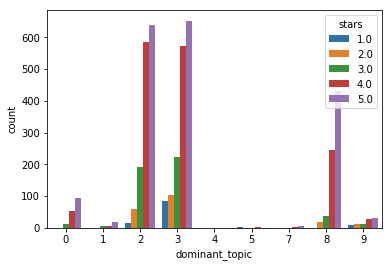

In [142]:
ax = sns.countplot(x='dominant_topic', hue='stars', data=df_document_topic)
#note that the 1-star reviews are clumping in about 3 lda-derived topics - one strongly
#but the topics that they cluster in are not dominated by them, so it's not terribly informative

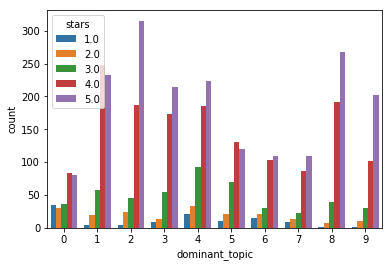

In [144]:
#repeating above process for NMF model
nmf_output = nmf.transform(data_vectorized)
topicnames = ["Topic" + str(i) for i in range(nmf.n_components)]
docnames = ["cleaned_review" + str(i) for i in range(len(included_reviews['review_cleaned']))]
df_document_topic = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic = df_document_topic.reset_index(drop=False)
df_document_topic['stars'] = included_reviews['stars']
df_document_topic['text'] = included_reviews['review_body']
ax = sns.countplot(x='dominant_topic', hue='stars', data=df_document_topic)

#interesting in that there now seems to be a single pretty-negative topic, but also the one- and two-star reviews are more spread out

### I honestly don't know that this graph down here is useful for anything, but it's an option and it's interactive:

In [145]:
svd_2d = TruncatedSVD(n_components=2)
data_2d = svd_2d.fit_transform(data_vectorized)

In [146]:
trace = go.Scattergl(
    x = data_2d[:,0],
    y = data_2d[:,1],
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    ),
    text = vectorizer.get_feature_names(),
    hovertext = vectorizer.get_feature_names(),
    hoverinfo = 'text' 
)
data = [trace]
iplot(data, filename='scatter-mode')

In [ ]:
trace = go.Scattergl(
    x = data_2d[:,0],
    y = data_2d[:,1],
    mode = 'text',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    ),
    text = vectorizer.get_feature_names()
)
data = [trace]
iplot(data, filename='text-scatter-mode')

### Moving past bag 'o words to bag 'o two-word phrases with Bigrams

In [147]:
def spacy_bigram_tokenizer(phrase):
    doc = parser(phrase) # create spacy object
    token_not_noun = []
    notnoun_noun_list = []
    noun = ""

    for item in doc:
        if item.pos_ != "NOUN": # separate nouns and not nouns
            token_not_noun.append(item.text)
        if item.pos_ == "NOUN":
            noun = item.text
        
        for notnoun in token_not_noun:
            notnoun_noun_list.append(notnoun + " " + noun)

    return " ".join([i for i in notnoun_noun_list])

In [148]:
bivectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, ngram_range=(1,2))
bigram_vectorized = bivectorizer.fit_transform(included_reviews['processed_reviews'])

In [149]:
bi_lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_bi_lda = bi_lda.fit_transform(bigram_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [150]:
print("Bi-LDA Model:")
selected_topics(bi_lda, bivectorizer)

Bi-LDA Model:
Topic 0:
[('patio great', 40.71630796725435), ('reasonably', 37.76428540364029), ('reasonably price', 29.81625957821638), ('table ready', 29.591334605972513), ('matt', 24.27907068895342), ('yes', 21.580644982866406), ('high quality', 18.590946905261713), ('great ambiance', 18.356301741951707), ('finnegan', 18.225199306960313), ('mother', 15.222579127583138)]
Topic 1:
[('wait', 1349.8392099164037), ('table', 514.1156462334047), ('seat', 424.3155159777795), ('people', 422.7673179427272), ('minute', 376.0238688610015), ('long', 332.29409698259366), ('come', 322.6608106667311), ('outside', 301.5447971857419), ('hour', 289.0557671619066), ('list', 267.9242504880697)]
Topic 2:
[('great', 740.326444283714), ('service', 726.9003291777976), ('breakfast', 468.91360726937353), ('love', 353.83214370779507), ('san', 294.63209535316656), ('coffee', 282.82038823736497), ('patio', 264.4540142193498), ('francisco', 258.2749745688378), ('san francisco', 257.23762952772825), ('favorite', 22

In [196]:
bi_dash = pyLDAvis.sklearn.prepare(bi_lda, bigram_vectorized, bivectorizer, mds='tsne')
bi_dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
6       77.891022    9.628959       1        1  43.092284
8      -92.304146    2.221428       2        1  15.826578
2      173.040344   63.711159       3        1  12.392663
1      -12.092181  -51.373062       4        1  10.613707
9        2.846432   56.307571       5        1   8.713197
4       92.830887  117.311638       6        1   4.418147
3      161.962448  -42.667065       7        1   2.985407
7        9.293991  165.562759       8        1   0.830715
5      -81.227890  108.599213       9        1   0.684407
0       71.440407  -99.629333      10        1   0.442893, topic_info=     Category         Freq                 Term        Total  loglift  logprob
term                                                                          
7146  Default  3565.000000                 wait  3565.000000  30.0000  30.0000
7501  Default   821.000000                worth   821.000000  29.0000  29.0000
4576  Default  1905.000000              pancake  1905.000000  28.0000  28.0000
1818  Default   902.000000               dinner   902.000000  27.0000  27.0000
6743  Default   560.000000                  tip   560.000000  26.0000  26.0000
5172  Default   578.000000                price   578.000000  25.0000  25.0000
6445  Default  1234.000000                table  1234.000000  24.0000  24.0000
2769  Default  1934.000000                great  1934.000000  23.0000  23.0000
457   Default   424.000000                bacon   424.000000  22.0000  22.0000
2700  Default   628.000000          gingerbread   628.000000  21.0000  21.0000
1178  Default   364.000000                 cole   364.000000  20.0000  20.0000
7523  Default   231.000000           worth wait   231.000000  19.0000  19.0000
3915  Default  1017.000000                 menu  1017.000000  18.0000  18.0000
5798  Default  1505.000000              service  1505.000000  17.0000  17.0000
5680  Default  1171.000000                 seat  1171.000000  16.0000  16.0000
7088  Default   312.000000               valley   312.000000  15.0000  15.0000
1182  Default   306.000000          cole valley   306.000000  14.0000  14.0000
4020  Default   677.000000               minute   677.000000  13.0000  13.0000
4727  Default  1209.000000                patio  1209.000000  12.0000  12.0000
3658  Default   974.000000                 long   974.000000  11.0000  11.0000
2702  Default   489.000000  gingerbread pancake   489.000000  10.0000  10.0000
7561  Default   221.000000                  yes   221.000000   9.0000   9.0000
4778  Default   290.000000                  pay   290.000000   8.0000   8.0000
772   Default  1241.000000            breakfast  1241.000000   7.0000   7.0000
4808  Default   724.000000               people   724.000000   6.0000   6.0000
4242  Default   383.000000                night   383.000000   5.0000   5.0000
3422  Default   562.000000                lemon   562.000000   4.0000   4.0000
3630  Default   323.000000                 live   323.000000   3.0000   3.0000
4190  Default  1008.000000                 nice  1008.000000   2.0000   2.0000
3169  Default   283.000000              include   283.000000   1.0000   1.0000
...       ...          ...                  ...          ...      ...      ...
1847  Topic10     9.638199          dinner spot    10.505882   5.3334  -4.7506
5109  Topic10     8.370767                  ppl     9.238548   5.3210  -4.8916
2401  Topic10    11.254341        finnegan wake    12.497268   5.3148  -4.5956
1807  Topic10     7.119695                  din     7.987358   5.3046  -5.0535
1630  Topic10     7.018113             decently     7.885744   5.3030  -5.0678
1943  Topic10     6.859162        door finnegan     7.727295   5.3004  -5.0907
6160  Topic10     6.443937               spirit     7.311545   5.2933  -5.1532
4102  Topic10     6.253106           mother day     7.120751   5.2897  -5.1833
4979  Topic10     6.05

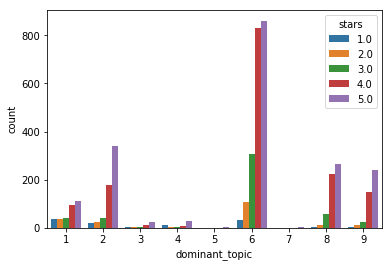

In [157]:
#let's append these bigrams to star data and plot it:
bi_lda_output = bi_lda.transform(bigram_vectorized)
topicnames = ["Topic" + str(i) for i in range(bi_lda.n_components)]
docnames = ["cleaned_review" + str(i) for i in range(len(included_reviews['review_cleaned']))]
df_document_topic = pd.DataFrame(np.round(bi_lda_output, 2), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic = df_document_topic.reset_index(drop=False)
df_document_topic['stars'] = included_reviews['stars']
df_document_topic['text'] = included_reviews['review_body']
ax = sns.countplot(x='dominant_topic', hue='stars', data=df_document_topic)

#looks like topic 1 is the negative one this time, and it did better than single-word LDA
#where does the 10th topic go?

In [158]:
print(max(df_document_topic['dominant_topic'])) 
print(min(df_document_topic['dominant_topic'])) #zero is gone!

9
1


In [161]:
print(range(bi_lda.n_components))
print(max(dominant_topic)) #oh, that's it - 10 was never the dominant topic, not for any row

range(0, 10)
9


### Moving past bag 'o two-words to bag 'o three-word phrases with Trigrams

In [162]:
def spacy_trigram_tokenizer(phrase):
    doc = parser(phrase) # create spacy object
    token_not_noun = []
    notnoun_noun_list = []
    noun = ""

    for item in doc:
        if item.pos_ != "NOUN": # separate nouns and not nouns
            token_not_noun.append(item.text)
        if item.pos_ == "NOUN":
            noun = item.text
        
        for notnoun in token_not_noun:
            notnoun_noun_list.append(notnoun + " " + noun)

    return " ".join([i for i in notnoun_noun_list])

In [163]:
trivectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, ngram_range=(2,3)) #will this adj be enough?
trigram_vectorized = trivectorizer.fit_transform(included_reviews['processed_reviews'])

In [200]:
tri_lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online', verbose=True)
data_tri_lda = tri_lda.fit_transform(trigram_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [201]:
print("Tri-LDA Model:")
selected_topics(tri_lda, trivectorizer)

Tri-LDA Model:
Topic 0:
[('mer benedict', 78.6125764117996), ('la mer', 71.985459085687), ('la mer benedict', 69.99545580137087), ('excellent service', 47.55632713944378), ('wait hour', 45.32641414353453), ('service friendly', 43.59232128585801), ('time wait', 42.42771078890905), ('wait time', 39.51059430716825), ('wait 20', 37.68948766875242), ('20 minute', 34.89461897834301)]
Topic 1:
[('great service', 115.88815256622564), ('cole valley', 93.52612204167247), ('service great', 91.11694450830025), ('onion soup', 62.637886227741674), ('highly recommend', 45.38599413795157), ('new york', 41.413075374647256), ('service excellent', 39.85981144164461), ('pork chop', 39.58612814087615), ('prepare wait', 39.08689284803433), ('creme brulee', 38.879032488783324)]
Topic 2:
[('worth wait', 120.9302328143509), ('long wait', 98.70086499682749), ('definitely worth', 80.86125964182702), ('15 minute', 77.45684727712366), ('hour wait', 75.22997150351391), ('deux trois', 47.63477052002042), ('buttermil

In [203]:
bi_dash = pyLDAvis.sklearn.prepare(tri_lda, trigram_vectorized, trivectorizer, mds='tsne')
bi_dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5      153.334686 -174.411179       1        1  15.458189
4      165.844559  313.314972       2        1  13.792328
9      -33.092812  229.283142       3        1  11.338192
7      -29.669954  -14.060681       4        1  11.040547
8      351.165497  161.741745       5        1   9.782583
6     -226.063644  132.331161       6        1   9.723256
1      -45.515064 -258.573181       7        1   8.093119
3      346.346069  -77.608154       8        1   7.022217
2     -230.849487 -107.034615       9        1   6.884282
0      149.932510   68.881744      10        1   6.865287, topic_info=     Category        Freq                       Term       Total  loglift  \
term                                                                        
1778  Default  473.000000        gingerbread pancake  473.000000  30.0000   
2231  Default  312.000000                 lemon curd  312.000000  29.0000   
2181  Default  305.000000                     la mer  305.000000  28.0000   
4839  Default  321.000000               toast tahiti  321.000000  27.0000   
5392  Default  229.000000                 worth wait  229.000000  26.0000   
2479  Default  280.000000                  long wait  280.000000  25.0000   
591   Default  139.000000         caramelized banana  139.000000  24.0000   
302   Default  151.000000              banana walnut  151.000000  23.0000   
1893  Default  119.000000              great service  119.000000  22.0000   
613   Default  107.000000              challah toast  107.000000  21.0000   
738   Default  302.000000                cole valley  302.000000  20.0000   
707   Default  123.000000                coffee cake  123.000000  19.0000   
2022  Default  325.000000                   home fry  325.000000  18.0000   
3904  Default  260.000000              san francisco  260.000000  17.0000   
3226  Default  119.000000              pancake lemon  119.000000  16.0000   
3854  Default  149.000000               roast garlic  149.000000  15.0000   
925   Default  109.000000               cream cheese  109.000000  14.0000   
1096  Default   76.000000           definitely worth   76.000000  13.0000   
2680  Default   75.000000               mer benedict   75.000000  12.0000   
4100  Default  133.000000              service great  133.000000  11.0000   
4199  Default  127.000000                sit outside  127.000000  10.0000   
26    Default   73.000000                  15 minute   73.000000   9.0000   
3227  Default  101.000000         pancake lemon curd  101.000000   8.0000   
447   Default  101.000000                bloody mary  101.000000   7.0000   
2074  Default   87.000000                  hour wait   87.000000   6.0000   
2050  Default   79.000000              hot chocolate   79.000000   5.0000   
2182  Default   67.000000            la mer benedict   67.000000   4.0000   
2252  Default   66.000000              lemon ricotta   66.000000   3.0000   
594   Default   76.000000  caramelized banana walnut   76.000000   2.0000   
2756  Default  156.000000            miracle pancake  156.000000   1.0000   
...       ...         ...                        ...         ...      ...   
3945  Topic10   13.361867           scramble chorizo   14.216521   2.6167   
3330  Topic10   13.305734                patio charm   14.160409   2.6164   
135   Topic10   13.216512                 amaze love   14.071099   2.6160   
3697  Topic10   12.917222               pricey worth   13.771826   2.6146   
5018  Topic10   12.876470               visit friend   13.731463   2.6144   
3354  Topic10   12.815621              patio outside   13.670575   2.6141   
5385  Topic10   12.795592                worth price   13.650145   2.6140   
476   Topic10   12.599301                bread toast   13.453911   2.6131   
2687  Topic10   12.578066         mer dungeness crab   13.432575   2.6130   
2686  Topic10   12.578061  

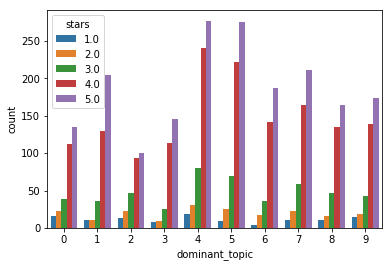

In [204]:
#let's append these bigrams to star data and plot it:
tri_lda_output = tri_lda.transform(trigram_vectorized)
topicnames = ["Topic" + str(i) for i in range(tri_lda.n_components)]
docnames = ["cleaned_review" + str(i) for i in range(len(included_reviews['review_cleaned']))]
df_document_topic = pd.DataFrame(np.round(tri_lda_output, 2), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic = df_document_topic.reset_index(drop=False)
df_document_topic['stars'] = included_reviews['stars']
df_document_topic['text'] = included_reviews['review_body']
ax = sns.countplot(x='dominant_topic', hue='stars', data=df_document_topic)

#this seems to have performed worse than the bigram approach for determining one angry cluster

### Compare log likelihood and perplexity scores between these approaches
- Relying heavily on: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
- Perplexity measures how well the model does when attempting to predict sentences
- Is inversely related to log-likelihood score per word
- Not really clear that it should be directly comparable between lda, bigram, and trigram models
### Also going to adjust some model parameters - kind of a clunky hypertuning approach, since grid search failed

In [211]:
#Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components = 2, max_iter = 10, learning_method = 'online') #default topic word prior (beta)...
#... is 1/n_components, so 1/2 in this case
data_lda = lda.fit_transform(data_vectorized)

print('Log Likelihood: ', lda.score(data_vectorized))
print('Perplexity: ', lda.perplexity(data_vectorized)) #note - slightly different with each run
#but always lowest (with default settings, anyway) at minimum topic number

#messing around with beta - perplexity score lowest at default beta:b
lda = LatentDirichletAllocation(n_components = 2, max_iter = 10, learning_method = 'online', topic_word_prior = 1/4)
data_lda = lda.fit_transform(data_vectorized)

print('Log Likelihood: ', lda.score(data_vectorized))
print('Perplexity: ', lda.perplexity(data_vectorized))

#messing around with beta:
lda = LatentDirichletAllocation(n_components = 2, max_iter = 10, learning_method = 'online', topic_word_prior = 1)
data_lda = lda.fit_transform(data_vectorized)

print('Log Likelihood: ', lda.score(data_vectorized))
print('Perplexity: ', lda.perplexity(data_vectorized))

Log Likelihood:  -1280400.32054728
Perplexity:  859.6726270903017
Log Likelihood:  -1283826.8765020052
Perplexity:  875.358277879405
Log Likelihood:  -1282139.150680783
Perplexity:  867.5969756880017


In [212]:
#messing around with an automatic check for perplexity score during iterations:
lda = LatentDirichletAllocation(n_components = 2, max_iter = 10, learning_method = 'online', evaluate_every = 1) 
data_lda = lda.fit_transform(data_vectorized)

print('Log Likelihood: ', lda.score(data_vectorized))
print('Perplexity: ', lda.perplexity(data_vectorized)) #no noticeable effect except a slower run

Log Likelihood:  -1280359.2227970012
Perplexity:  859.4862110053949


In [213]:
#Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components = 5, max_iter = 10, learning_method = 'online')
data_lda = lda.fit_transform(data_vectorized)

print('Log Likelihood: ', lda.score(data_vectorized))
print('Perplexity: ', lda.perplexity(data_vectorized))

#messing around with beta at n = 5 topics:
lda = LatentDirichletAllocation(n_components = 5, max_iter = 10, learning_method = 'online', topic_word_prior = 1/10)
data_lda = lda.fit_transform(data_vectorized)

print('Log Likelihood: ', lda.score(data_vectorized))
print('Perplexity: ', lda.perplexity(data_vectorized))

lda = LatentDirichletAllocation(n_components = 5, max_iter = 10, learning_method = 'online', topic_word_prior = 1/2.5)
data_lda = lda.fit_transform(data_vectorized)

print('Log Likelihood: ', lda.score(data_vectorized))
print('Perplexity: ', lda.perplexity(data_vectorized)) #oh well hey... higher beta (prior expectation that most topics...
#... will contain most of the corpus' words) seems to work out for n = 5 topics

Log Likelihood:  -1287566.257821242
Perplexity:  892.8027084615057
Log Likelihood:  -1286997.4840031418
Perplexity:  890.1270982340593
Log Likelihood:  -1282802.426640751
Perplexity:  870.6389242069743


In [214]:
#Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components = 5, max_iter = 10, learning_method = 'online', evaluate_every = 1) #try that auto-perplexity check again
data_lda = lda.fit_transform(data_vectorized)

print('Log Likelihood: ', lda.score(data_vectorized))
print('Perplexity: ', lda.perplexity(data_vectorized))
#a little helpful! maybe adjusting these hyperparameters is more helpful with high k-values

Log Likelihood:  -1286515.024641382
Perplexity:  887.8638125774374


In [215]:
#Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components = 9, max_iter = 10, learning_method = 'online')
data_lda = lda.fit_transform(data_vectorized)

print('Log Likelihood: ', lda.score(data_vectorized))
print('Perplexity: ', lda.perplexity(data_vectorized))

#again, playing around with beta, but now for k = 10:
lda = LatentDirichletAllocation(n_components = 9, max_iter = 10, learning_method = 'online', topic_word_prior = 1/20)
data_lda = lda.fit_transform(data_vectorized)

print('Log Likelihood: ', lda.score(data_vectorized))
print('Perplexity: ', lda.perplexity(data_vectorized))
lda = LatentDirichletAllocation(n_components = 9, max_iter = 10, learning_method = 'online', topic_word_prior = 1/5)
data_lda = lda.fit_transform(data_vectorized)

print('Log Likelihood: ', lda.score(data_vectorized))
print('Perplexity: ', lda.perplexity(data_vectorized))
#no, increasing beta did not help at n = 10

Log Likelihood:  -1294059.2245940107
Perplexity:  923.9226889408242
Log Likelihood:  -1295953.1466101757
Perplexity:  933.2027116518718
Log Likelihood:  -1295077.6437096628
Perplexity:  928.9013091254308


In [216]:
#Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components = 9, max_iter = 10, learning_method = 'online', evaluate_every = 1) #adding that auto-perp check in
data_lda = lda.fit_transform(data_vectorized)

print('Log Likelihood: ', lda.score(data_vectorized))
print('Perplexity: ', lda.perplexity(data_vectorized))
#not terribly helpful

Log Likelihood:  -1296040.6148588837
Perplexity:  933.6335416954215


In [184]:
#with default setting and n_components at 10

#log likelihood; higher is better better
print('Log Likelihood: ', lda.score(data_vectorized))

#perplexity: lower the better. perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', lda.perplexity(data_vectorized))

#best perplexity score (lowest)

Log Likelihood:  -1296650.403402806
Perplexity:  936.6426232375698


In [230]:
#ok, let's try a range of k-values:
min_k = 1
max_k = 10
for k in range(min_k,max_k+1):
    lda = LatentDirichletAllocation(n_components = k, max_iter = 10, learning_method = 'online', evaluate_every = 1) #adding that auto-perp check in
    data_lda = lda.fit_transform(data_vectorized)
    print(k)
    print('Log Likelihood: ', lda.score(data_vectorized))
    print('Perplexity: ', lda.perplexity(data_vectorized))
#indicates a sweet spot at 3 topics, and I would have missed that without this for-loop
#let's run this again, but cut out that evaluate = 1 argument

1
Log Likelihood:  -1285172.7841231506
Perplexity:  881.5974011175311
2
Log Likelihood:  -1283581.3963104666
Perplexity:  874.2250940552352
3
Log Likelihood:  -1278973.881295841
Perplexity:  853.2260048217655
4
Log Likelihood:  -1282913.720578715
Perplexity:  871.1503898313402
5
Log Likelihood:  -1289203.089050649
Perplexity:  900.5476058261954
6
Log Likelihood:  -1289498.6086012847
Perplexity:  901.9530412323643
7
Log Likelihood:  -1291918.2845014692
Perplexity:  913.5433772379448
8
Log Likelihood:  -1292388.1745913283
Perplexity:  915.8113786897006
9
Log Likelihood:  -1295360.6230458277
Perplexity:  930.2894320350543
10
Log Likelihood:  -1297858.7287822796
Perplexity:  942.6339424004296


In [231]:
#as above, to see if results repeat, but now without evaluate = 1 built in
min_k = 1
max_k = 10
for k in range(min_k,max_k+1):
    lda = LatentDirichletAllocation(n_components = k, max_iter = 10, learning_method = 'online') #adding that auto-perp check in
    data_lda = lda.fit_transform(data_vectorized)
    print(k)
    print('Log Likelihood: ', lda.score(data_vectorized))
    print('Perplexity: ', lda.perplexity(data_vectorized))
    
#k = 3 is still a sweet spot

1
Log Likelihood:  -1285172.784121601
Perplexity:  881.5974011103212
2
Log Likelihood:  -1280990.7573368168
Perplexity:  862.3552681801764
3
Log Likelihood:  -1280207.7466306007
Perplexity:  858.7994763154445
4
Log Likelihood:  -1282884.1448382612
Perplexity:  871.014441400503
5
Log Likelihood:  -1286909.6086064978
Perplexity:  889.7144329278361
6
Log Likelihood:  -1288646.4001729123
Perplexity:  897.9060437990667
7
Log Likelihood:  -1292348.1381252208
Perplexity:  915.6179168901496
8
Log Likelihood:  -1294027.8180635385
Perplexity:  923.7695805705099
9
Log Likelihood:  -1296359.4877415402
Perplexity:  935.2058539423379
10
Log Likelihood:  -1297186.1785174955
Perplexity:  939.2944787201783


In [232]:
#try this approach with the bigram models
min_k = 1
max_k = 10
for k in range(min_k,max_k+1):
    bi_lda = LatentDirichletAllocation(n_components = k, max_iter = 10, learning_method = 'online') #adding that auto-perp check in
    data_lda = bi_lda.fit_transform(bigram_vectorized)
    print(k)
    print('Log Likelihood: ', bi_lda.score(bigram_vectorized))
    print('Perplexity: ', bi_lda.perplexity(bigram_vectorized))
    
#k = 3 is STILL a sweet spot, but I think perplexity can only be compared within monogram, bigram, and trigram sets, not between sets

1
Log Likelihood:  -1925884.6276472674
Perplexity:  2104.839875257648
2
Log Likelihood:  -1919213.1917868385
Perplexity:  2049.7794550832405
3
Log Likelihood:  -1913854.6765229313
Perplexity:  2006.5996181672306
4
Log Likelihood:  -1919996.9452734024
Perplexity:  2056.172494680066
5
Log Likelihood:  -1928244.7267450702
Perplexity:  2124.6702775693916
6
Log Likelihood:  -1927122.6904850602
Perplexity:  2115.219335108471
7
Log Likelihood:  -1929341.7447210357
Perplexity:  2133.951314590202
8
Log Likelihood:  -1932921.4896008847
Perplexity:  2164.519746378212
9
Log Likelihood:  -1935570.8163202445
Perplexity:  2187.424691106295
10
Log Likelihood:  -1937260.032595584
Perplexity:  2202.155309948032


In [233]:
#wonder if 3 will also be the sweetspot k value for trigrams?
min_k = 1
max_k = 10
for k in range(min_k,max_k+1):
    tri_lda = LatentDirichletAllocation(n_components = k, max_iter = 10, learning_method = 'online') #adding that auto-perp check in
    data_lda = tri_lda.fit_transform(trigram_vectorized)
    print(k)
    print('Log Likelihood: ', tri_lda.score(trigram_vectorized))
    print('Perplexity: ', tri_lda.perplexity(trigram_vectorized))
    
#nope, k = 1 now... trigrams do not seem to be the way to go with this data-set

1
Log Likelihood:  -547493.2492241589
Perplexity:  3829.919301265161
2
Log Likelihood:  -549133.4377889555
Perplexity:  3925.7640795364423
3
Log Likelihood:  -554071.6683942431
Perplexity:  4229.056915238768
4
Log Likelihood:  -556103.3036871204
Perplexity:  4360.537368852173
5
Log Likelihood:  -557457.228003112
Perplexity:  4450.420702827955
6
Log Likelihood:  -560995.6939664482
Perplexity:  4694.17562108964
7
Log Likelihood:  -562740.0634917123
Perplexity:  4819.208791949488
8
Log Likelihood:  -562227.3581562235
Perplexity:  4782.117358689142
9
Log Likelihood:  -565306.8339766868
Perplexity:  5009.271083610467
10
Log Likelihood:  -564174.7470317517
Perplexity:  4924.536304821541


In [191]:
#nmf doesn't output a score for this exact approach to work with

In [192]:
#lsi doesn't output a score for this exact approach to work with

In [179]:
#log likelihood; higher is better better
print('Log Likelihood: ', bi_lda.score(bigram_vectorized))

#perplexity: lower the better. perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', bi_lda.perplexity(bigram_vectorized))

Log Likelihood:  -1938758.9857507898
Perplexity:  2215.309808655095


In [180]:
#log likelihood; higher is better better
print('Log Likelihood: ', tri_lda.score(trigram_vectorized))

#perplexity: lower the better. perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', tri_lda.perplexity(trigram_vectorized))

#best log likelihood score (lowest)

Log Likelihood:  -565419.8526770582
Perplexity:  5017.809974141565


### Let's see what the topics look like when using k = 3 for monogram and bigram models

In [239]:
NUM_TOPICS = 3

In [240]:
#Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online')
data_lda = lda.fit_transform(data_vectorized)
#should cross-validation have been applied?

In [241]:
#keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer)

#topics pretty mixed up - NMF once again did better

LDA Model:
Topic 0:
[('wait', 1490.9282334693646), ('time', 939.3423630983482), ('service', 856.4896995383173), ('great', 855.3399674085834), ('table', 822.1683892535071), ('come', 808.0627499028751), ('like', 580.4155152058605), ('seat', 564.5970280498308), ('people', 520.8259943104915), ('little', 499.0655393177121)]
Topic 1:
[('wait', 1993.895247056305), ('toast', 1798.2416141505348), ('order', 1066.3542732155865), ('come', 1052.338408122923), ('benedict', 1050.3295147132008), ('pancake', 944.9332311383423), ('breakfast', 828.7531630767495), ('poach', 815.29187791954), ('like', 813.2492090873893), ('try', 778.5773532943991)]
Topic 2:
[('pancake', 896.1880531295532), ('dinner', 724.1000475356093), ('lemon', 552.7074323880313), ('great', 483.7356349484107), ('delicious', 386.28471857003854), ('like', 354.57809146380083), ('night', 349.7844810369082), ('gingerbread', 344.1563804311702), ('curd', 334.76239723239013), ('order', 313.20734657147466)]


In [242]:
#alternatively: Non-Negative Matrix Factorization Model - might as well try this one again, too, and LSI as well
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized) 

In [243]:
#keywords for topics clustered by Non-Negative Matrix Factorization
print("NMF Model:")
selected_topics(nmf, vectorizer)

#topic 1: time
#topic 2: breakfast
#topic 3: all else

NMF Model:
Topic 0:
[('wait', 8.617019580220628), ('table', 1.843902651551653), ('long', 1.8338725242358116), ('time', 1.8125694234447618), ('seat', 1.7827364072475442), ('come', 1.7150307790498505), ('worth', 1.503624543756053), ('hour', 1.393112933272497), ('minute', 1.3823061801820564), ('order', 1.226115238648716)]
Topic 1:
[('pancake', 5.651795540749324), ('toast', 3.6716154778384977), ('gingerbread', 1.8121482883289926), ('lemon', 1.7196971326972437), ('order', 1.5641060974092558), ('like', 1.468555074520409), ('try', 1.2321272642639782), ('curd', 1.1851668814970122), ('come', 1.115497848637818), ('benedict', 1.1075553694231945)]
Topic 2:
[('great', 2.3007024593845187), ('come', 2.207168505245645), ('like', 2.1390547218467586), ('order', 1.7100105586171075), ('service', 1.6440101298266059), ('menu', 1.5805316343414537), ('dinner', 1.4811954768008202), ('time', 1.4633335421692275), ('love', 1.4247183115819757), ('dish', 1.3172667346618407)]


In [244]:
#alternatively: Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

In [245]:
#keywords for topics clustered by Latent Semantic Indexing
print("LSI Model:")
selected_topics(lsi, vectorizer)

#topic 1: time and breakfast
#topic 2: time
#topic 3: dinner

LSI Model:
Topic 0:
[('wait', 0.36040919142860883), ('come', 0.2478828394380281), ('order', 0.21625902197584512), ('toast', 0.20301928867301897), ('pancake', 0.19852350467093766), ('like', 0.18826314778425712), ('time', 0.17268927858549477), ('great', 0.15246650130450026), ('table', 0.14159726009744453), ('try', 0.14022947412579514)]
Topic 1:
[('wait', 0.588079021428099), ('table', 0.1470662560675843), ('long', 0.11518619822826312), ('time', 0.10558858072546244), ('seat', 0.09815009693515223), ('minute', 0.09438505091330028), ('hour', 0.0879015753275987), ('worth', 0.0873908658972594), ('people', 0.07497274423710083), ('list', 0.0720605621718343)]
Topic 2:
[('dinner', 0.2613942595903219), ('great', 0.22986784001437452), ('menu', 0.14361984139891626), ('service', 0.1379329767078948), ('night', 0.13232294023837463), ('dessert', 0.11246290573930522), ('wine', 0.11056254546962621), ('like', 0.10739533776123598), ('love', 0.09972580048800828), ('dish', 0.09373353840205408)]


In [247]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
1      -632.045471 -384.325073       1        1  42.294215
0     -1209.665405  212.164124       2        1  36.652330
2     -1437.453247 -586.322510       3        1  21.053455, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
2632  Default  1931.000000        toast  1931.000000  30.0000  30.0000
1815  Default  1922.000000      pancake  1922.000000  29.0000  29.0000
744   Default   927.000000       dinner   927.000000  28.0000  28.0000
234   Default  1099.000000     benedict  1099.000000  27.0000  27.0000
1464  Default   553.000000        lemon   553.000000  26.0000  26.0000
2783  Default  3571.000000         wait  3571.000000  25.0000  25.0000
1923  Default   849.000000        poach   849.000000  24.0000  24.0000
648   Default   325.000000         curd   325.000000  23.0000  23.0000
1704  Default   394.000000        night   394.000000  22.0000  22.0000
1107  Default   628.000000  gingerbread   628.000000  21.0000  21.0000
604   Default   485.000000         crab   485.000000  20.0000  20.0000
727   Default   270.000000      dessert   270.000000  19.0000  19.0000
2392  Default   264.000000         soup   264.000000  18.0000  18.0000
446   Default   468.000000       cheese   468.000000  17.0000  17.0000
2846  Default   287.000000         wine   287.000000  16.0000  16.0000
2562  Default   451.000000       tahiti   451.000000  15.0000  15.0000
1959  Default   751.000000       potato   751.000000  14.0000  14.0000
199   Default   423.000000       banana   423.000000  13.0000  13.0000
1073  Default   475.000000          fry   475.000000  12.0000  12.0000
2217  Default   485.000000        sauce   485.000000  11.0000  11.0000
833   Default   403.000000         eggs   403.000000  10.0000  10.0000
1854  Default   191.000000         pear   191.000000   9.0000   9.0000
310   Default   341.000000        bread   341.000000   8.0000   8.0000
461   Default   188.000000    chocolate   188.000000   7.0000   7.0000
1597  Default   347.000000          mer   347.000000   6.0000   6.0000
2231  Default   466.000000     scramble   466.000000   5.0000   5.0000
1086  Default   476.000000       garlic   476.000000   4.0000   4.0000
1256  Default   335.000000  hollandaise   335.000000   3.0000   3.0000
1865  Default   548.000000      perfect   548.000000   2.0000   2.0000
1862  Default   714.000000       people   714.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
2035   Topic3    88.622502      pudding    94.220277   1.4969  -6.1097
867    Topic3   136.350186       entree   157.427849   1.4144  -5.6788
1815   Topic3   867.949496      pancake  1922.551038   0.7628  -3.8279
446    Topic3   292.719029       cheese   468.157930   1.0885  -4.9149
310    Topic3   218.446845        bread   341.433104   1.1115  -5.2075
1107   Topic3   333.312139  gingerbread   628.491604   0.9239  -4.7850
2689   Topic3   111.840448      tuesday   134.791454   1.3714  -5.8770
2800   Topic3   203.629897         warm   351.491914   1.0122  -5.2778
616    Topic3   157.978623        cream   247.992189   1.1072  -5.5316
2217   Topic3   225.073471        sauce   485.517491   0.7893  -5.1776
705    Topic3   374.113029    delicious  1226.924768   0.3704  -4.6695
1150   Topic3   468.493302        great  1959.952464   0.1270  -4.4445
380    Topic3   157.238050         cake   264.004595   1.0399  -5.5363
1596   Topic3   292.659881         menu  1019.245363   0.3103  -4.9151
758    Topic3   275.667670         dish   900.152143   0.3747  -4.9749
771    Topic3   126.829635          dog   174.993373   1.2362  -5.7512
1479   Topic3   343.405466         like  1762.883640  -0.0777  -4.7552
1849   Topic3   288.511955        patio  1229.732473   0.1083  -4.9293
2687   Topic3   299.938178          try  

In [249]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(nmf, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
2      -632.045471 -384.325073       1        1  48.701393
0     -1209.665405  212.164124       2        1  27.152800
1     -1437.453247 -586.322510       3        1  24.145807, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
2783  Default  4157.000000         wait  4157.000000  30.0000  30.0000
1815  Default  2496.000000      pancake  2496.000000  29.0000  29.0000
2632  Default  2198.000000        toast  2198.000000  28.0000  28.0000
1107  Default   800.000000  gingerbread   800.000000  27.0000  27.0000
1464  Default   759.000000        lemon   759.000000  26.0000  26.0000
1504  Default  1027.000000         long  1027.000000  25.0000  25.0000
2556  Default  1458.000000        table  1458.000000  24.0000  24.0000
2864  Default   796.000000        worth   796.000000  23.0000  23.0000
1281  Default   722.000000         hour   722.000000  22.0000  22.0000
648   Default   523.000000         curd   523.000000  21.0000  21.0000
1629  Default   813.000000       minute   813.000000  20.0000  20.0000
2245  Default  1361.000000         seat  1361.000000  19.0000  19.0000
744   Default   767.000000       dinner   767.000000  18.0000  18.0000
199   Default   515.000000       banana   515.000000  17.0000  17.0000
2562  Default   540.000000       tahiti   540.000000  16.0000  16.0000
1479  Default  1814.000000         like  1814.000000  15.0000  15.0000
1862  Default   815.000000       people   815.000000  14.0000  14.0000
1489  Default   588.000000         list   588.000000  13.0000  13.0000
2625  Default  1743.000000         time  1743.000000  12.0000  12.0000
2544  Default   550.000000        sweet   550.000000  11.0000  11.0000
1631  Default   308.000000      miracle   308.000000  10.0000  10.0000
1854  Default   286.000000         pear   286.000000   9.0000   9.0000
1782  Default   753.000000      outside   753.000000   8.0000   8.0000
1836  Default   428.000000        party   428.000000   7.0000   7.0000
1923  Default   863.000000        poach   863.000000   6.0000   6.0000
2575  Default   654.000000        taste   654.000000   5.0000   5.0000
758   Default   985.000000         dish   985.000000   4.0000   4.0000
2796  Default   327.000000       walnut   327.000000   3.0000   3.0000
234   Default  1097.000000     benedict  1097.000000   2.0000   2.0000
997   Default   496.000000       flavor   496.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
2074   Topic3    61.581847    raspberry    66.069264   1.3507  -6.6107
396    Topic3   211.938532  caramelized   244.405648   1.2785  -5.3748
2562   Topic3   444.805710       tahiti   540.603615   1.2260  -4.6335
1816   Topic3   162.397770     pancakes   187.287270   1.2785  -5.6411
2632   Topic3  1621.533016        toast  2198.817439   1.1165  -3.3400
427    Topic3   146.400529      challah   184.785061   1.1882  -5.7448
1895   Topic3   212.243615        piece   281.279308   1.1394  -5.3734
2544   Topic3   378.878729        sweet   550.034785   1.0483  -4.7939
2339   Topic3   173.781479        slice   245.198080   1.0768  -5.5733
1923   Topic3   475.614606        poach   863.438527   0.8247  -4.5665
2495   Topic3   182.574117        stuff   267.910702   1.0376  -5.5240
997    Topic3   293.693538       flavor   496.162845   0.8967  -5.0486
234    Topic3   489.140982     benedict  1097.905429   0.6126  -4.5385
2605   Topic3   104.934154        thick   140.486538   1.1293  -6.0778
315    Topic3   458.389081    breakfast  1059.494022   0.5832  -4.6034
2575   Topic3   319.955592        taste   654.226249   0.7058  -4.9629
2687   Topic3   544.156939          try  1396.189236   0.4788  -4.4319
1479   Topic3   648.572966         like  1814.299525   0.3924  -4.2563
1770   Topic3   690.772139        order  

In [250]:
#method to identify the dominant cluster for every review
#because the reviews are labeled with stars, this will be super handy
lda_output = lda.transform(data_vectorized)

#column names
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]

#index names
docnames = ["cleaned_review" + str(i) for i in range(len(included_reviews['review_cleaned']))]

#make the df
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

#fetch dominant topics by row
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()
#now get stars in there!

,Topic0,Topic1,Topic2,dominant_topic
cleaned_review0,0.73,0.27,0.01,0
cleaned_review1,0.88,0.00,0.11,0
cleaned_review2,0.09,0.73,0.18,1
cleaned_review3,0.01,0.80,0.19,1
cleaned_review4,0.00,0.64,0.36,1


In [251]:
df_document_topic = df_document_topic.reset_index(drop=False)

df_document_topic['stars'] = included_reviews['stars']
df_document_topic['text'] = included_reviews['review_body']

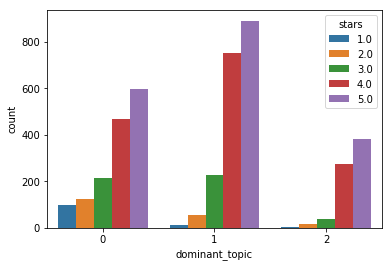

In [252]:
ax = sns.countplot(x='dominant_topic', hue='stars', data=df_document_topic)
#most negative reviews are in one topic, but still this 3-topic LDA isn't very informative

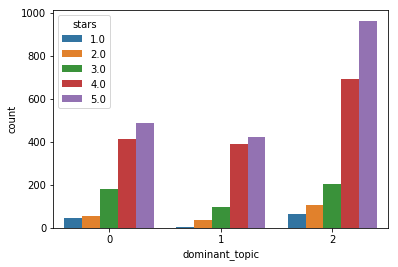

In [253]:
#repeating above process for NMF model
nmf_output = nmf.transform(data_vectorized)
topicnames = ["Topic" + str(i) for i in range(nmf.n_components)]
docnames = ["cleaned_review" + str(i) for i in range(len(included_reviews['review_cleaned']))]
df_document_topic = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic = df_document_topic.reset_index(drop=False)
df_document_topic['stars'] = included_reviews['stars']
df_document_topic['text'] = included_reviews['review_body']
ax = sns.countplot(x='dominant_topic', hue='stars', data=df_document_topic)

#3 topics hasn't helped NMF much either

### Let's just do the most positive (4 and 5) and, separately, most negative reviews (1 and 2) - may get more informative clustering there

In [254]:
# subset df down to just the most negative bins; 1-2 star reviews
bad_reviews = included_reviews[(included_reviews['stars']==1.0)|(included_reviews['stars']==2.0)]

In [255]:
bad_reviews.head()

,Unnamed: 0,author,date,stars,review_body,review_cleaned,processed_reviews
9,9,Hayoung P.,2019-02-25,1.0,"Found a hair in the miracle pancakes, and aske...",find hair miracle pancake ask manager remove p...,found hair miracle pancake ask manager remove ...
16,16,Shirley M. J.,2018-12-04,2.0,12/01/2018: ZAZIE from what my daughter and s...,daughter son law andy proclaim go breakfast re...,12/01/2018 daughter son law andy proclaim brea...
18,18,Michelle Z.,2019-02-25,1.0,Tl;dr: we found HAIR IN OUR FOOD and when we c...,tldr find hair confront manager incredibly rud...,tl;dr find hair confront manager incredibly ru...
41,41,Y K.,2019-01-18,1.0,"Worst experience of my life at a restaurant, h...",bad experience life restaurant hand hate take ...,worst experience life hand hate like ruin 10 y...
43,43,S C.,2019-03-08,1.0,The food is good. I sat at the corner table ...,sit corner table drop key disgusted find rat d...,sit corner table drop key disgust find rat dro...


In [256]:
#let's see what the sentiment scores at this lower end look like in higher resolution
#should look just the same as with the full data-set, right?

#create a basic pre-processed corpus, don't lowercase to get POS context
#'doc' is created within normalize_corpus function
corpus = normalize_corpus(bad_reviews['review_body'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
df = pd.DataFrame([list(bad_reviews['stars']), sentiment_scores, sentiment_category]).T
df.columns = ['stars', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['stars']).describe()

#yes, exactly the same! sanity check checked

sentiment_score                                                 
                count      mean        std   min  25%  50%   75%   max
stars                                                                 
1.0             114.0 -1.631579   9.916700 -62.0 -5.0 -1.0   3.0  20.0
2.0             195.0  7.071795  10.569113 -21.0  0.0  5.0  11.0  53.0

In [257]:
# Creating a Spacy object
nlp = spacy.load('en_core_web_lg')

In [313]:
#stripping this back down to the basic stopword list for now
#the most-common low-information words for the negative reveiw
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
#first pass additions, after intial modeling produces 2 topics with heavy overlap regardless of approach:
stopwords.append('food') 
stopwords.append('good')
stopwords.append('come')
stopwords.append('wait')
#second round of negative review keywords added after second round of negative review modeling:
stopwords.append('zazie') 
stopwords.append('place') 
stopwords.append('time')
stopwords.append('order')
stopwords.append('table')

In [314]:
review = str(" ".join([i.lemma_ for i in doc]))

In [315]:
doc = nlp(review)
spacy.displacy.render(doc, style='ent',jupyter=True)
#no difference from above if we start with review_cleaned above, as review_cleaned has...
#... already been pre-processed 

In [316]:
#parser for reviews
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [317]:
tqdm.pandas()
bad_reviews['processed_reviews'] = bad_reviews['review_body'].progress_apply(spacy_tokenizer)

100%|██████████| 309/309 [00:00<00:00, 366.28it/s]


In [318]:
#creating a vectorizer
#soon with custom stopwords
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words=stopwords, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(bad_reviews['processed_reviews'])

In [319]:
#skipping straight ahead to the LDA model selection step - then back to NMF and LSI
#as above, to see if results repeat, but now without evaluate = 1 built in
min_k = 1
max_k = 10
for k in range(min_k,max_k+1):
    lda = LatentDirichletAllocation(n_components = k, max_iter = 10, learning_method = 'online') 
    data_lda = lda.fit_transform(data_vectorized)
    print(k)
    print('Log Likelihood: ', lda.score(data_vectorized))
    print('Perplexity: ', lda.perplexity(data_vectorized))
    
#k = 2 is a sweet spot after round 1 and 2 of added stopwords... going to try this again below with priors adjusted (beta)

1
Log Likelihood:  -83459.62152839836
Perplexity:  467.37538795966367
2
Log Likelihood:  -83307.05030567851
Perplexity:  462.15266793178205
3
Log Likelihood:  -84108.28166598517
Perplexity:  490.2469089700304
4
Log Likelihood:  -84650.03674891476
Perplexity:  510.2044739299024
5
Log Likelihood:  -85205.00940460767
Perplexity:  531.491665193351
6
Log Likelihood:  -85066.31647503847
Perplexity:  526.0899630950557
7
Log Likelihood:  -85795.64554943914
Perplexity:  555.1232799012371
8
Log Likelihood:  -85804.05503418313
Perplexity:  555.4672253093463
9
Log Likelihood:  -86307.70007259154
Perplexity:  576.4594882696622
10
Log Likelihood:  -86506.13821798134
Perplexity:  584.9467534248614


In [320]:
#as above, but now beta is 1/2 as large for each k
min_k = 1
max_k = 10
for k in range(min_k,max_k+1):
    lda = LatentDirichletAllocation(n_components = k, max_iter = 10, learning_method = 'online', topic_word_prior = 1/(2*k))
    data_lda = lda.fit_transform(data_vectorized)
    print(k)
    print('Log Likelihood: ', lda.score(data_vectorized))
    print('Perplexity: ', lda.perplexity(data_vectorized))
    
#perplexity is higher with the lower beta; k = 1 is the sweetspot; don't do this

1
Log Likelihood:  -83605.63148264888
Perplexity:  472.4287664343723
2
Log Likelihood:  -83854.90481805107
Perplexity:  481.18265992002443
3
Log Likelihood:  -84268.22602105755
Perplexity:  496.0564334451999
4
Log Likelihood:  -84995.34815990775
Perplexity:  523.3472136403078
5
Log Likelihood:  -86258.44136393131
Perplexity:  574.3718252290145
6
Log Likelihood:  -85875.70276082569
Perplexity:  558.406251499804
7
Log Likelihood:  -86355.62478789534
Perplexity:  578.4978968429
8
Log Likelihood:  -86820.14602034715
Perplexity:  598.6330138678418
9
Log Likelihood:  -87388.47227023974
Perplexity:  624.2233470681355
10
Log Likelihood:  -87692.96624521635
Perplexity:  638.3810892063075


In [321]:
#as above, but now beta is twice as large for each k
min_k = 1
max_k = 10
for k in range(min_k,max_k+1):
    lda = LatentDirichletAllocation(n_components = k, max_iter = 10, learning_method = 'online', topic_word_prior = 2/k)
    data_lda = lda.fit_transform(data_vectorized)
    print(k)
    print('Log Likelihood: ', lda.score(data_vectorized))
    print('Perplexity: ', lda.perplexity(data_vectorized))
    
#perplexity also higher with larger beta for each k; leave k alone

1
Log Likelihood:  -83447.32968369732
Perplexity:  466.9524443112252
2
Log Likelihood:  -83787.97162304436
Perplexity:  478.81631725937103
3
Log Likelihood:  -84325.9975445972
Perplexity:  498.171701451207
4
Log Likelihood:  -84163.99819338093
Perplexity:  492.2628903106725
5
Log Likelihood:  -84359.66872142855
Perplexity:  499.40870849144494
6
Log Likelihood:  -84751.55659791456
Perplexity:  514.0337449343125
7
Log Likelihood:  -84881.01549145694
Perplexity:  518.958582177243
8
Log Likelihood:  -84986.19824214924
Perplexity:  522.9946342231733
9
Log Likelihood:  -85717.72134351433
Perplexity:  551.9463158318531
10
Log Likelihood:  -85509.13060711311
Perplexity:  543.5312763137867


In [322]:
bivectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, ngram_range=(1,2))
bigram_vectorized = bivectorizer.fit_transform(bad_reviews['processed_reviews'])

In [323]:
#try this approach with the bigram models and negative reviews only
min_k = 1
max_k = 10
for k in range(min_k,max_k+1):
    bi_lda = LatentDirichletAllocation(n_components = k, max_iter = 10, learning_method = 'online') 
    data_lda = bi_lda.fit_transform(bigram_vectorized)
    print(k)
    print('Log Likelihood: ', bi_lda.score(bigram_vectorized))
    print('Perplexity: ', bi_lda.perplexity(bigram_vectorized))

#that's not good - 1 topic isn't terribly informative
#on second pass, after adding negative review specific stopwords, 2 topics is the sweetspot - that's an improvement
#on third pass, 2 also the sweetspot - again worth revisiting this approach

1
Log Likelihood:  -92686.62505907328
Perplexity:  542.7483258160811
2
Log Likelihood:  -92463.78346822805
Perplexity:  534.593705328821
3
Log Likelihood:  -93645.36375464706
Perplexity:  579.2750621824885
4
Log Likelihood:  -93800.89800544915
Perplexity:  585.4282405193156
5
Log Likelihood:  -94081.09470153261
Perplexity:  596.6786633493898
6
Log Likelihood:  -94916.36451208394
Perplexity:  631.5155649905579
7
Log Likelihood:  -94579.58327405278
Perplexity:  617.2310511593623
8
Log Likelihood:  -95058.87350869038
Perplexity:  637.6591588670433
9
Log Likelihood:  -95070.40189360212
Perplexity:  638.1587553086233
10
Log Likelihood:  -95669.09643109066
Perplexity:  664.6491240602543


In [324]:
#ok, let's look a this 2-topic bad reviews monogram LDA
lda = LatentDirichletAllocation(n_components = 2, max_iter = 10, learning_method = 'online')
data_lda = lda.fit_transform(data_vectorized)

print("LDA Model:")
selected_topics(lda, vectorizer)

#after two rounds of added stopwords, very distinct topics
#topic 0 is service, ask, restaurant, server, seat, minute, eat, waiter, tell, little
#topic 1 is relatively benign: egg, brunch, like, toast, french, pancake, breakfast, coffee, dish, service

LDA Model:
Topic 0:
[('service', 121.86798402626007), ('ask', 105.30993717685064), ('restaurant', 100.06077173954608), ('server', 94.76039367392923), ('seat', 83.41532767595359), ('minute', 82.24937527923872), ('eat', 74.29680694816619), ('waiter', 72.90454418439569), ('tell', 70.77734772816888), ('little', 66.73723800606288)]
Topic 1:
[('egg', 164.3551889607518), ('brunch', 102.71974401419071), ('like', 98.76130646088043), ('toast', 97.29936007008965), ('french', 90.19654968339817), ('pancake', 81.61582254142641), ('breakfast', 65.86222489466384), ('coffee', 53.448993555729686), ('dish', 50.74676253338387), ('service', 50.28659282154904)]


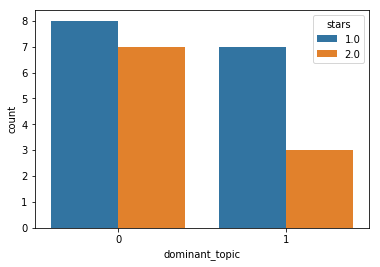

In [326]:
#let's see what this looks like... are these more confused star assignments? maybe mixed reviews?
lda_output = lda.transform(data_vectorized)
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]
docnames = ["cleaned_review" + str(i) for i in range(len(bad_reviews['review_cleaned']))]
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic = df_document_topic.reset_index(drop=False)
df_document_topic['stars'] = bad_reviews['stars']
df_document_topic['text'] = bad_reviews['review_body']
ax = sns.countplot(x='dominant_topic', hue='stars', data=df_document_topic)

#huh... yeah, a little confusion there, maybe some mixed reviews

In [327]:
#sentiment statistics per topic
df = pd.DataFrame([list(df_document_topic['dominant_topic']), sentiment_scores, sentiment_category]).T
df.columns = ['dominant_topic', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['dominant_topic']).describe()

#yes, topic 1 is objectively angrier by sentiment score

sentiment_score                                              \
                         count      mean        std   min   25%  50%   75%   
dominant_topic                                                               
0                        164.0  1.463415  11.693105 -62.0 -3.25  0.0   7.0   
1                        145.0  6.572414   9.838095 -16.0  0.00  4.0  10.0   

                      
                 max  
dominant_topic        
0               53.0  
1               44.0

In [328]:
#does the nmf or lsi approach do any better?
nmf = NMF(n_components=2)
data_nmf = nmf.fit_transform(data_vectorized) 
print("NMF Model:")
selected_topics(nmf, vectorizer)

#not really an improvement after stopwords tailored twice - but better up until then

NMF Model:
Topic 0:
[('service', 1.6695384868174592), ('ask', 1.6592389499673914), ('server', 1.4560769676268899), ('restaurant', 1.4279639085062088), ('tell', 1.3511261872549607), ('friend', 1.2984383767892922), ('experience', 1.2097305236503857), ('seat', 1.1975028770487894), ('tip', 1.1466174836539786), ('sure', 1.1030734900366521)]
Topic 1:
[('egg', 2.5088970179926693), ('toast', 1.614322400041442), ('french', 1.5735627778779102), ('like', 1.5038943652385117), ('pancake', 1.2186045139680133), ('brunch', 1.1050556043012758), ('breakfast', 1.0908641468055886), ('coffee', 0.8797515582317393), ('taste', 0.8191161815054755), ('little', 0.7621740092064094)]


In [329]:
lsi = TruncatedSVD(n_components=2)
data_lsi = lsi.fit_transform(data_vectorized)
print("LSI Model:")
selected_topics(lsi, vectorizer)

#redundant with nmf model output after two round of stopwords tailoring

LSI Model:
Topic 0:
[('egg', 0.20326699508114843), ('service', 0.20159775847978972), ('like', 0.1893397555672474), ('restaurant', 0.16875790489329992), ('ask', 0.15769849109579703), ('brunch', 0.15716033498528503), ('friend', 0.14646770670873516), ('dish', 0.14472081152572547), ('think', 0.14018496366426728), ('server', 0.13874994545755498)]
Topic 1:
[('ask', 0.18969916409524257), ('tell', 0.16550824075172332), ('server', 0.16276168873703037), ('sure', 0.15930448186625132), ('experience', 0.11452013384978346), ('job', 0.10982478696949469), ('service', 0.10408990914523643), ('tip', 0.10327102044715715), ('friend', 0.10265948586081085), ('list', 0.09582769297991164)]


In [330]:
#after adding second round of negative-review keywords, it's again worth looking at the bigram output:
bi_lda = LatentDirichletAllocation(n_components = 2, max_iter = 10, learning_method = 'online')
data_bi_lda = bi_lda.fit_transform(bigram_vectorized)

print("Bi-LDA Model:")
selected_topics(bi_lda, bivectorizer) #some bigrams now apparent
#topic 1 seems angry

Bi-LDA Model:
Topic 0:
[('egg', 176.9471646799219), ('toast', 92.91377140740957), ('pancake', 87.01721981898632), ('like', 84.88809886650624), ('coffee', 82.41547004418527), ('french', 79.34329611633108), ('breakfast', 67.61079543919884), ('french toast', 65.80397700224897), ('service', 61.63356465610404), ('minute', 53.191018405973004)]
Topic 1:
[('service', 110.51953716276081), ('restaurant', 98.50849878861632), ('brunch', 98.15305212283694), ('ask', 83.30544923530914), ('like', 79.61300218845554), ('waiter', 76.71833748565399), ('want', 69.20953917601817), ('tell', 66.63850864074033), ('little', 63.19988544085936), ('menu', 61.45196009433401)]


In [331]:
bi_dash = pyLDAvis.sklearn.prepare(bi_lda, bigram_vectorized, bivectorizer, mds='tsne')
bi_dash

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
1     -60.312317  141.369629       1        1  53.656832
0      60.312561 -141.369141       2        1  46.343168, topic_info=     Category        Freq                 Term       Total  loglift  logprob
term                                                                        
225   Default  181.000000                  egg  181.000000  30.0000  30.0000
481   Default   86.000000              pancake   86.000000  29.0000  29.0000
690   Default   95.000000                toast   95.000000  28.0000  28.0000
140   Default   88.000000               coffee   88.000000  27.0000  27.0000
283   Default   66.000000         french toast   66.000000  26.0000  26.0000
77    Default   52.000000             benedict   52.000000  25.0000  25.0000
64    Default   39.000000                bacon   39.000000  24.0000  24.0000
204   Default   42.000000               dinner   42.000000  23.0000  23.0000
294   Default   27.000000          gingerbread   27.000000  22.0000  22.0000
281   Default  104.000000               french  104.000000  21.0000  21.0000
596   Default   57.000000                serve   57.000000  20.0000  20.0000
675   Default   56.000000                taste   56.000000  19.0000  19.0000
407   Default   35.000000              manager   35.000000  18.0000  18.0000
723   Default   93.000000               waiter   93.000000  17.0000  17.0000
504   Default   38.000000                poach   38.000000  16.0000  16.0000
560   Default  124.000000           restaurant  124.000000  15.0000  15.0000
515   Default   45.000000               potato   45.000000  14.0000  14.0000
290   Default   26.000000               garlic   26.000000  13.0000  13.0000
295   Default   22.000000  gingerbread pancake   22.000000  12.0000  12.0000
374   Default   60.000000                leave   60.000000  11.0000  11.0000
422   Default   73.000000                 menu   73.000000  10.0000  10.0000
680   Default   80.000000                 tell   80.000000   9.0000   9.0000
587   Default   26.000000             scramble   26.000000   8.0000   8.0000
505   Default   30.000000            poach egg   30.000000   7.0000   7.0000
183   Default   65.000000             customer   65.000000   6.0000   6.0000
166   Default   21.000000                 crab   21.000000   5.0000   5.0000
68    Default   19.000000               banana   19.000000   4.0000   4.0000
346   Default   37.000000                 hype   37.000000   3.0000   3.0000
442   Default   18.000000               muffin   18.000000   2.0000   2.0000
234   Default   17.000000              english   17.000000   1.0000   1.0000
...       ...         ...                  ...         ...      ...      ...
227    Topic2   16.821498         egg benedict   18.823236   0.6567  -6.0052
180    Topic2   23.236413                  cup   26.785815   0.6269  -5.6821
744    Topic2   14.920423                 wife   16.618113   0.6613  -6.1251
515    Topic2   37.710037               potato   45.577711   0.5796  -5.1979
114    Topic2   20.423845                 card   23.434856   0.6316  -5.8112
675    Topic2   45.489100                taste   56.523190   0.5519  -5.0104
346    Topic2   31.079274                 hype   37.925997   0.5700  -5.3913
281    Topic2   74.713252               french  104.781899   0.4309  -4.5142
499    Topic2   19.884189                piece   23.508611   0.6017  -5.8379
93     Topic2   63.665397            breakfast  102.746337   0.2905  -4.6742
382    Topic2   79.934490                 like  160.378050   0.0728  -4.4467
1      Topic2   40.301338                   10   62.687971   0.3273  -5.1315
501    Topic2   43.833955                plate   73.396685   0.2536  -5.0475
753    Topic2   40.420978                worth   66.173715   0.2762  -5.1285
125    Topic2   34.114605                check   52.716505   0.3339  -5.2981
430    Topic2   50.087079        

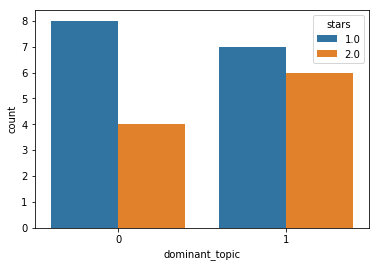

In [332]:
#let's append these bigrams to star data and plot it:
bi_lda_output = bi_lda.transform(bigram_vectorized)
topicnames = ["Topic" + str(i) for i in range(bi_lda.n_components)]
docnames = ["cleaned_review" + str(i) for i in range(len(bad_reviews['review_cleaned']))]
df_document_topic = pd.DataFrame(np.round(bi_lda_output, 2), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic = df_document_topic.reset_index(drop=False)
df_document_topic['stars'] = bad_reviews['stars']
df_document_topic['text'] = bad_reviews['review_body']
ax = sns.countplot(x='dominant_topic', hue='stars', data=df_document_topic)

#topic 1 seems to contain the most reviews
#what's up with the topic 0 1-star reviews that appear to be about nothing but brunch?

In [333]:
#sentiment statistics per topic
df = pd.DataFrame([list(df_document_topic['dominant_topic']), sentiment_scores, sentiment_category]).T
df.columns = ['dominant_topic', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['dominant_topic']).describe()

#topic 0 is noticeably angrier during this last pass bigrams

sentiment_score                                             \
                         count      mean        std   min  25%  50%   75%   
dominant_topic                                                              
0                        137.0  5.131387   9.812071 -18.0 -1.0  4.0  10.0   
1                        172.0  2.848837  12.028735 -62.0 -2.0  2.0   9.0   

                      
                 max  
dominant_topic        
0               40.0  
1               53.0

### Insight 1: the angriest customers may not be the customers leaving the lowest-star ratings: 

In [306]:
#after adding first round of negative-review keywords, it's now worth looking at the bigram output:
bi_lda = LatentDirichletAllocation(n_components = 2, max_iter = 10, learning_method = 'online')
data_bi_lda = bi_lda.fit_transform(bigram_vectorized)

print("Bi-LDA Model:")
selected_topics(bi_lda, bivectorizer) #these don't even look like bigrams

Bi-LDA Model:
Topic 0:
[('egg', 189.5900577676422), ('place', 179.96060465299865), ('like', 123.7132341103644), ('order', 109.8935433706609), ('toast', 99.51386996610785), ('brunch', 98.45554128894425), ('service', 92.87071994178348), ('french', 90.77044918126427), ('zazie', 89.25534977927958), ('breakfast', 87.4023756862332)]
Topic 1:
[('table', 139.634086759931), ('ask', 91.70776830222373), ('zazie', 88.3739450987943), ('time', 79.70117517850274), ('service', 79.28590711253032), ('restaurant', 77.6266486613798), ('order', 76.28323952321492), ('seat', 70.89631479823467), ('server', 68.36062782955196), ('tell', 65.82929758641833)]


In [309]:
bi_dash = pyLDAvis.sklearn.prepare(bi_lda, bigram_vectorized, bivectorizer, mds='tsne')
bi_dash

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  54.035882
1      60.312561 -141.369141       2        1  45.964118, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
228   Default  177.000000           egg  177.000000  30.0000  30.0000
711   Default   93.000000         toast   93.000000  29.0000  29.0000
688   Default  190.000000         table  190.000000  28.0000  28.0000
287   Default   65.000000  french toast   65.000000  27.0000  27.0000
52    Default  119.000000           ask  119.000000  26.0000  26.0000
494   Default   85.000000       pancake   85.000000  25.0000  25.0000
698   Default   82.000000          tell   82.000000  24.0000  24.0000
205   Default   43.000000        dinner   43.000000  23.0000  23.0000
77    Default   51.000000      benedict   51.000000  22.0000  22.0000
513   Default  207.000000         place  207.000000  21.0000  21.0000
249   Default   81.000000    experience   81.000000  20.0000  20.0000
415   Default   36.000000       manager   36.000000  19.0000  19.0000
629   Default   67.000000           sit   67.000000  18.0000  18.0000
64    Default   38.000000         bacon   38.000000  17.0000  17.0000
215   Default   36.000000          door   36.000000  16.0000  16.0000
605   Default  100.000000          seat  100.000000  15.0000  15.0000
141   Default   88.000000        coffee   88.000000  14.0000  14.0000
530   Default   44.000000        potato   44.000000  13.0000  13.0000
570   Default   25.000000   reservation   25.000000  12.0000  12.0000
585   Default   39.000000          rude   39.000000  11.0000  11.0000
341   Default   39.000000          host   39.000000  10.0000  10.0000
613   Default  100.000000        server  100.000000   9.0000   9.0000
184   Default   65.000000      customer   65.000000   8.0000   8.0000
285   Default  103.000000        french  103.000000   7.0000   7.0000
747   Default   35.000000          walk   35.000000   6.0000   6.0000
499   Default   42.000000         party   42.000000   5.0000   5.0000
351   Default   37.000000          hype   37.000000   4.0000   4.0000
299   Default   26.000000   gingerbread   26.000000   3.0000   3.0000
693   Default   55.000000         taste   55.000000   2.0000   2.0000
520   Default   30.000000     poach egg   30.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
605    Topic2   73.676303          seat  100.929003   0.4626  -4.5894
478    Topic2   20.479066          open   24.030117   0.6174  -5.8697
184    Topic2   49.498718      customer   65.897884   0.4911  -4.9872
320    Topic2   23.442176        happen   28.066743   0.5973  -5.7346
613    Topic2   71.041187        server  100.713282   0.4283  -4.6259
380    Topic2   44.276797         leave   60.607768   0.4633  -5.0987
574    Topic2   80.670547    restaurant  125.018906   0.3392  -4.4988
745    Topic2   63.093282        waiter   93.571911   0.3832  -4.7445
122    Topic2   21.079672        change   25.412111   0.5904  -5.8408
709    Topic2   46.188002           tip   65.875949   0.4223  -5.0564
392    Topic2   39.081176          list   54.113896   0.4519  -5.2235
503    Topic2   35.334365         patio   47.777167   0.4756  -5.3243
438    Topic2   62.311991        minute  100.721958   0.2971  -4.7570
375    Topic2   33.433420          late   45.266530   0.4743  -5.3796
789    Topic2   91.839267         zazie  174.777680   0.1338  -4.3691
225    Topic2   59.273112           eat   98.444155   0.2700  -4.8070
750    Topic2   55.163257          want   89.564525   0.2926  -4.8788
705    Topic2   82.826420          time  158.079224   0.1310  -4.4724
612    Topic2   39.591543         serve   57.882704   0.3975  -5.2105
614    Topic2   82.394868       service  168.692778   0.0608  -4.4776
481    Topic2   79.

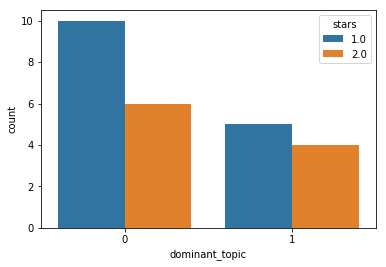

In [311]:
#let's append these bigrams to star data and plot it:
bi_lda_output = bi_lda.transform(bigram_vectorized)
topicnames = ["Topic" + str(i) for i in range(bi_lda.n_components)]
docnames = ["cleaned_review" + str(i) for i in range(len(bad_reviews['review_cleaned']))]
df_document_topic = pd.DataFrame(np.round(bi_lda_output, 2), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic = df_document_topic.reset_index(drop=False)
df_document_topic['stars'] = bad_reviews['stars']
df_document_topic['text'] = bad_reviews['review_body']
ax = sns.countplot(x='dominant_topic', hue='stars', data=df_document_topic)

#topic 0 (1 above) is the angriest topic by stars, which is odd because topic 1 is the angriest by words (subjectively)
#wonder what the sentiment scores on these topics are...

In [312]:
#sentiment statistics per topic
df = pd.DataFrame([list(df_document_topic['dominant_topic']), sentiment_scores, sentiment_category]).T
df.columns = ['dominant_topic', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['dominant_topic']).describe()

#yeah, 1 is notably angrier by sentiment score, too - but not by star values

sentiment_score                                             \
                         count      mean        std   min  25%  50%   75%   
dominant_topic                                                              
0                        164.0  5.182927   9.684125 -21.0 -1.0  3.0  10.0   
1                        145.0  2.365517  12.454257 -62.0 -3.0  2.0   8.0   

                      
                 max  
dominant_topic        
0               40.0  
1               53.0